In [1]:
from __future__ import annotations
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Tuple
import os
import re
import sys
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pprint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, accuracy_score
pd.set_option('display.max_columns', None)
from lightgbm import LGBMClassifier, LGBMRegressor

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
def bad_line_handler(bad_line):
    print(f"Skipping line: {bad_line}")

df = pd.read_csv(r'D:\College\NUIG\Thesis\BERPublicsearch.txt', sep='\t', on_bad_lines=bad_line_handler,engine='python', encoding='latin1')

# Data Preprocessing

## Data Cleaning

In [4]:
df = df.drop(columns=['SA_Code','ThirdWallType_Description','SecondWallType_Description','FirstWallDescription','SecondEnerProdComment','FirstEnerProdComment','SecondWallDescription','FirstWallType_Description','ThirdWallDescription','gsdSHRenewableResources','gsdWHRenewableResources','FirstEnerConsumedComment','SecondEnerConsumedComment','ThirdEnerProdComment','ThirdEnerConsumedComment','FirstEnergyType_Description','SecondEnergyType_Description','ThirdEnergyType_Description','FirstWallIsSemiExposed','SecondWallIsSemiExposed','ThirdWallIsSemiExposed'])

In [5]:
# 1. Areas – must be strictly positive
area_cols = [
    "WallArea","RoofArea","FloorArea","WindowArea","DoorArea",
    "GroundFloorArea","FirstFloorArea","SecondFloorArea","ThirdFloorArea"
]
for col in area_cols:
    df = df[df[col] >= 0]
df.shape

(1287510, 190)

### Replacing NaN values with "No Info"

In [6]:
columns_to_update = [
    "StorageLosses", "ManuLossFactorAvail", "SolarHotWaterHeating", "PrimaryCircuitLoss"
]

# Replace NaN with "No Info" in those columns
df[columns_to_update] = df[columns_to_update].fillna("No Info")


In [7]:
columns_to_update = [
    "StorageLosses", "ManuLossFactorAvail", "SolarHotWaterHeating", "PrimaryCircuitLoss","ElecImmersionInSummer","CombiBoiler","KeepHotFacility","InsulationType"
]

# Replace NaN with "No Info" in those columns
df[columns_to_update] = df[columns_to_update].fillna("No Info")

In [8]:
# BER Cannot be negative and realistically highest BER Rating can be over 750
df = df[df['BerRating'] >= 0]

In [9]:
df = df[df['BerRating'] <= 750].reset_index(drop=True)
df.shape

(1270646, 190)

-- Source
- The Irish TABULA typology (SEAI-supported stock archetypes) includes several “actual state” pre-1977 houses in the 600–650 kWh/m²/yr range and an electric-heating variant at 733 kWh/m²/yr — a good benchmark for a realistic upper end.
- Case studies of very poor pre-retrofit homes (e.g., Dingle Rd., Cabra) show G values around 458–501 kWh/m²/yr, illustrating that many G’s cluster just above the threshold — the 700s are the outliers. So I took an higher estimate of 750
- https://www.dublincity.ie/built-last-case-studies/energy-renovated-case-studies/case-study-dingle-road-cabra-west-mid-terrace-two-storey-house-1942/


In [10]:
# df.to_csv("Thesis_Data_1.csv", index=False)

In [11]:
df = pd.read_csv("Thesis_Data_1.csv")

In [12]:
# Assuming df is your DataFrame
null_counts = df.isnull().sum()

print(null_counts)

CountyName                   0
DwellingTypeDescr            0
Year_of_Construction         0
TypeofRating                 0
EnergyRating                 0
                         ...  
RER                     728849
RenewEPnren             728851
RenewEPren              728851
CPC                     626371
EPC                     626371
Length: 190, dtype: int64


In [13]:
# #For mixed type columns
# mixed_type_columns = [64,65,66,71]

# # Get the column names using their index positions
# column_names = df.columns[mixed_type_columns]

# # Display the first few rows of these columns
# print(df[column_names].head())

## Handling Missing Values

In [14]:
# 1. Fill simple defaults
simple_defaults = {
    "MainSpaceHeatingFuel": "Heating Oil",
    "MainWaterHeatingFuel": "Heating Oil",
    "InsulationThickness": 30,
    "VentilationMethod": "Natural ventilation",
    "SHRenewableResources": "No",
    "WHRenewableResources": "No",
    "SolarSpaceHeatingSystem": 0,
    "NoOfOpenFlues": 0,
    "NoOfFluelessGasFires": 0,
    "DraftLobby": "NO",
}
df.fillna(simple_defaults, inplace=True)

In [15]:
# 2. Conditional default for PermeabilityTestResult:
#    - If ventilation is 'Natural ventilation' -> use 0.25 ac/h
#    - If ventilation is 'Balanced whole-house mechanical ventilation' (with or without heat recovery) -> use 0.15 ac/h

def default_permeability(row):
    if pd.notna(row['PermeabilityTestResult']):
        return row['PermeabilityTestResult']
    if row['VentilationMethod'].lower().startswith("balanced"):
        return 0.15
    else:
        return 0.25

df['PermeabilityTestResult'] = df.apply(default_permeability, axis=1)

In [16]:
# 3. Conditional default for NoOfChimneys:
#    - For apartments (e.g., 'Ground-floor apartment', 'Apartment') use 0
#    - For other dwelling types use 1

def default_chimneys(row):
    if pd.notna(row['NoOfChimneys']):
        return row['NoOfChimneys']
    dwelling = str(row.get('DwellingTypeDescr', '')).lower()
    if 'apartment' in dwelling:
        return 0
    else:
        return 1

df['NoOfChimneys'] = df.apply(default_chimneys, axis=1)

In [17]:
# 4. Conditional default for NoOfFansAndVents:
#    - For apartments -> default to 1 (often just a bathroom fan)
#    - For other dwellings -> default to 2 (kitchen and bathroom)
def default_fans_vents(row):
    if pd.notna(row['NoOfFansAndVents']):
        return row['NoOfFansAndVents']
    dwelling = str(row.get('DwellingTypeDescr', '')).lower()
    if 'apartment' in dwelling:
        return 1
    else:
        return 2

df['NoOfFansAndVents'] = df.apply(default_fans_vents, axis=1)

In [18]:
# 5. Conditional default for PercentageDraughtStripped:
#    - If building year of construction is unknown, keep at 100% if new; if older, use 80% as a conservative estimate
def default_draught_stripping(row):
    if pd.notna(row['PercentageDraughtStripped']):
        return row['PercentageDraughtStripped']
    year = row.get('Year_of_Construction')
    # Use 100% for new dwellings (year >= 2010), else 80%
    try:
        if pd.notna(year) and int(year) >= 2010:
            return 100
        else:
            return 80
    except:
        return 80

df['PercentageDraughtStripped'] = df.apply(default_draught_stripping, axis=1)

In [19]:
# 6. Optional: Convert certain columns to numeric types
numeric_cols = [
    'InsulationThickness', 'PermeabilityTestResult',
    'NoOfChimneys', 'NoOfOpenFlues', 'NoOfFansAndVents',
    'NoOfFluelessGasFires', 'PercentageDraughtStripped'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [20]:
# mixed_type_cols = []

# for col in df.select_dtypes(include=['object', 'category']).columns:
#     types_in_col = df[col].map(type).unique()
#     if len(types_in_col) > 1:
#         mixed_type_cols.append((col, types_in_col))

# # Display the results
# for col, types in mixed_type_cols:
#     print(f"Column '{col}' contains multiple types: {types}")

In [21]:
# columns_to_check = [
#     'MainSpaceHeatingFuel',
#     'MainWaterHeatingFuel',
#     'DraftLobby',
#     'VentilationMethod',
#     'StructureType',
#     'SuspendedWoodenFloor',
#     'PermeabilityTest',
#     'PredominantRoofType'
# ]

# for col in columns_to_check:
#     if col in df.columns:
#         print(f"\nUnique values in '{col}':")
#         print(df[col].unique())
#     else:
#         print(f"\nColumn '{col}' not found in DataFrame.")

In [22]:
def clean_text_cols(df, cols, fill_value="No Info"):
    out = df.copy()
    out[cols] = out[cols].astype("string")

    # Strip spaces
    out[cols] = out[cols].apply(lambda s: s.str.strip())

    # Turn empty strings (were whitespace-only) into NA, then fill
    out[cols] = out[cols].replace("", pd.NA)
    out[cols] = out[cols].fillna(fill_value)
    return out

In [23]:
cols_to_clean = [
    "MainSpaceHeatingFuel",
    "MainWaterHeatingFuel",
    "DraftLobby",
    "VentilationMethod",
    "StructureType",
    "SuspendedWoodenFloor",
    "PermeabilityTest",
    "PredominantRoofType",
]

df = clean_text_cols(df, cols_to_clean)

In [24]:
def clean_renewable_resource_cols(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = (
            pd.to_numeric(
                out[c]
                .astype("string")          # handle mixed types
                .str.strip()               # trim spaces
                .replace(re.compile(r"^no$", re.I), "0"),  # "No" -> "0" (case-insensitive)
                errors="coerce"            # anything non-numeric -> NaN
            )
            .fillna(0.0)                   # missing/NaN -> 0.0
            .astype(float)
        )
    return out

In [25]:
# Use it:
cols_rr = ["SHRenewableResources", "WHRenewableResources"]
df = clean_renewable_resource_cols(df, cols_rr)

In [26]:
mixed_type_cols = []

for col in df.select_dtypes(include=['object', 'category']).columns:
    types_in_col = df[col].map(type).unique()
    if len(types_in_col) > 1:
        mixed_type_cols.append((col, types_in_col))

# Display the results
for col, types in mixed_type_cols:
    print(f"Column '{col}' contains multiple types: {types}")

In [27]:
for col in cols_rr:
    if col in df.columns:
        print(col)
        print(df[col].unique())

SHRenewableResources
[2. 1. 0. 5. 6. 3. 4.]
WHRenewableResources
[2. 1. 0. 5. 3. 6. 4.]


In [28]:
df = pd.read_csv("Thesis_Data_2.csv")

## Feature Selection

In [30]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [31]:
target_cols_to_predict = [
    "BerRating",
    "EnergyRating",
    "CO2Rating",
    "UValueWall",
    "UValueRoof",
    "UValueFloor",
    "UValueWindow",
    "UvalueDoor",
]

In [32]:

def Randomforest_model(df: pd.DataFrame, target_cols_to_predict):
    for target_col in target_cols_to_predict:

        print(f"\n=== Predicting Target: {target_col} ===")
        
        X = df.drop(columns=[target_col])
        y = df[target_col]


# Two models
        
        if y.dtype == 'object' or pd.api.types.is_categorical_dtype(y):
            task = 'classification'
            model = RandomForestClassifier(random_state=42)
            if not pd.api.types.is_numeric_dtype(y):
                y = y.astype('category').cat.codes
        else:
            task = 'regression'
            model = RandomForestRegressor(random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if task == 'classification':
            acc = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {acc:.4f}")
        else:
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            print(f"R²: {r2:.4f}, MSE: {mse:.4f}")



        
        # Display top 10 feature importances
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=X.columns)
        top10 = feat_imp.sort_values(ascending=False).head(10)

        print("Top 10 influential features:")
        print(top10.to_string())

In [33]:
Randomforest_model(df, target_cols_to_predict)


=== Predicting Target: BerRating ===
R²: 0.9925, MSE: 110.9508
Top 10 influential features:
EnergyRating               0.976851
CO2Rating                  0.012640
MainSpaceHeatingFuel       0.000974
UValueWall                 0.000580
HSMainSystemEfficiency     0.000458
HeatSystemResponseCat      0.000431
EPC                        0.000417
FirstWallUValue            0.000367
NoOilBoilerHeatingPumps    0.000314
MainWaterHeatingFuel       0.000220

=== Predicting Target: EnergyRating ===
R²: 1.0000, MSE: 0.0005
Top 10 influential features:
BerRating                            1.0
CountyName                           0.0
HESSchemeUpgrade                     0.0
LowEnergyLightingPercent             0.0
TotalDeliveredEnergy                 0.0
DeliveredEnergySecondarySpace        0.0
DeliveredEnergySupplementaryWater    0.0
LivingAreaPercent                    0.0
CO2SecondarySpace                    0.0
CO2SupplementaryWater                0.0

=== Predicting Target: CO2Rating ===
R²: 0

#### No use since all target columns are dependent on predicting each other

In [34]:
def Random_Forest_no_leakage(df: pd.DataFrame, target_cols_to_predict):
    for target_col in target_cols_to_predict:

        print(f"\n=== Predicting Target: {target_col} ===")

        # Prevent leakage by dropping all target columns from features
        features_to_exclude = target_cols_to_predict
        X = df.drop(columns=features_to_exclude)
        y = df[target_col]


        
        if pd.api.types.is_categorical_dtype(y) or y.dtype == 'object':
            task = 'classification'
            model = RandomForestClassifier(random_state=42)
            if not pd.api.types.is_numeric_dtype(y):
                y = y.astype('category').cat.codes
        else:
            task = 'regression'
            model = RandomForestRegressor(random_state=42)

# Pre-Processing to Handle Strings ----------------------------------------
        numeric_cols = X.select_dtypes(include=['number', 'bool']).columns.tolist()
        cat_cols = [c for c in X.columns if c not in numeric_cols]

        numeric_tf = SimpleImputer(strategy='median')
        categorical_tf = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))  # keeps new/rare cats safe
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_tf, numeric_cols),
                ('cat', categorical_tf, cat_cols),
            ]
        )

        pipe = Pipeline(steps=[
            ('pre', preprocessor),
            ('model', model),
        ])
# -------------------------------------------------------------------------
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Fit & predict
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # Evaluate
        if task == 'classification':
            acc = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {acc:.4f}")
        else:
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            print(f"R²: {r2:.4f}, MSE: {mse:.4f}")

        # Top 10 feature importances
        importances = pipe.named_steps['model'].feature_importances_

        # Get transformed feature names in the same order as ColumnTransformer output
        feature_names = []
        if numeric_cols:
            feature_names.extend(numeric_cols)
        if cat_cols:
            ohe = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
            feature_names.extend(ohe.get_feature_names_out(cat_cols).tolist())

        feat_imp = pd.Series(importances, index=feature_names)
        top10 = feat_imp.sort_values(ascending=False).head(10)

        print("Top 10 influential features:")
        print(top10.to_string())

In [35]:
Random_Forest_no_leakage(df, target_cols_to_predict)


=== Predicting Target: BerRating ===
R²: 0.9502, MSE: 734.6789
Top 10 influential features:
EPC                         0.457718
MPCDERValue                 0.234830
FirstWallUValue             0.199532
PrimaryEnergyMainSpace      0.013596
HSMainSystemEfficiency      0.008276
GroundFloorArea(sq m)       0.005047
Year_of_Construction        0.004581
DeliveredEnergyMainSpace    0.004096
SecondWallUValue            0.003671
CO2MainSpace                0.002998

=== Predicting Target: EnergyRating ===
R²: 0.9585, MSE: 0.5495
Top 10 influential features:
EPC                         0.622640
MPCDERValue                 0.174692
FirstWallUValue             0.115275
HSMainSystemEfficiency      0.012493
PrimaryEnergyMainSpace      0.005644
Year_of_Construction        0.004606
WHMainSystemEff             0.003844
GroundFloorArea(sq m)       0.003705
DeliveredEnergyMainSpace    0.003385
SecondWallUValue            0.002497

=== Predicting Target: CO2Rating ===
R²: 0.9654, MSE: 35.0853
Top 10 inf

In [36]:
df = pd.read_csv("Thesis_Data_2.csv")

In [37]:
selected_columns = [
    "CountyName","DwellingTypeDescr", "Year_of_Construction", "GroundFloorArea(sq m)", "WallArea", "RoofArea", "FloorArea",
    "WindowArea", "DoorArea", "NoStoreys", "MainSpaceHeatingFuel", "MainWaterHeatingFuel", "InsulationType",
    "InsulationThickness", "VentilationMethod", "PermeabilityTestResult", "HeatSystemControlCat",
    "HeatSystemResponseCat", "ThermalMassCategory", "LowEnergyLightingPercent", "SHRenewableResources",
    "WHRenewableResources", "SolarHotWaterHeating", "SolarSpaceHeatingSystem", "NoOfChimneys", "NoOfOpenFlues",
    "NoOfFansAndVents", "NoOfFluelessGasFires", "DraftLobby", "PercentageDraughtStripped", "BerRating", "CO2Rating",
    "UValueWall", "UValueRoof", "UValueFloor", "UValueWindow", "UvalueDoor","EnergyRating"
]

df = df[selected_columns]

In [38]:
df = pd.read_csv("Thesis_Data_2_Reduced.csv")

In [40]:
Random_Forest_no_leakage(df, target_cols_to_predict)


=== Predicting Target: BerRating ===
R²: 0.7757, MSE: 3307.5674
Top 10 influential features:
Year_of_Construction         0.481332
HeatSystemControlCat         0.062801
GroundFloorArea(sq m)        0.055703
HeatSystemResponseCat        0.053199
WindowArea                   0.036963
PercentageDraughtStripped    0.033844
WallArea                     0.028778
FloorArea                    0.021045
NoOfChimneys                 0.019338
DoorArea                     0.017112

=== Predicting Target: EnergyRating ===
Accuracy: 0.3690
Top 10 influential features:
Year_of_Construction         0.102243
GroundFloorArea(sq m)        0.061298
WindowArea                   0.059086
WallArea                     0.058084
FloorArea                    0.052626
RoofArea                     0.052117
DoorArea                     0.048544
NoOfFansAndVents             0.038227
PercentageDraughtStripped    0.030180
HeatSystemControlCat         0.028336

=== Predicting Target: CO2Rating ===
R²: 0.8050, MSE: 197.

In [127]:

def lgbm_no_leakage(df: pd.DataFrame, target_cols_to_predict):
    for target_col in target_cols_to_predict:

        print(f"\n=== Predicting Target: {target_col} ===")

        # Prevent leakage by dropping ALL target columns from features
        X = df.drop(columns=target_cols_to_predict).copy()
        y = df[target_col].copy()

        # Identify column types
        num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
        cat_cols = [c for c in X.columns if c not in num_cols]

        # Preprocessing: impute + one-hot encode categoricals (no leakage: fit on train only)
        pre = ColumnTransformer(
            transformers=[
                ("num", SimpleImputer(strategy="median"), num_cols),
                ("cat", Pipeline([
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe", OneHotEncoder(handle_unknown="ignore"))
                ]), cat_cols),
            ],
            remainder="drop",
        )

        # Task & model
        if pd.api.types.is_categorical_dtype(y) or y.dtype == "object":
            task = "classification"
            # encode y if needed
            if not pd.api.types.is_numeric_dtype(y):
                y = y.astype("category").cat.codes
            model = lgb.LGBMClassifier(random_state=42)
            stratify = y
        else:
            task = "regression"
            model = lgb.LGBMRegressor(random_state=42)
            stratify = None

        # Pipeline: preprocessing -> model
        pipe = Pipeline(steps=[("pre", pre), ("model", model)])

        # Split, fit, predict, evaluate
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=stratify
        )
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        if task == "classification":
            acc = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {acc:.4f}")
        else:
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            print(f"R²: {r2:.4f}, MSE: {mse:.4f}")


In [42]:
lgbm_no_leakage(df, target_cols_to_predict)


=== Predicting Target: BerRating ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 113
[LightGBM] [Info] Start training from score 203.249946
R²: 0.8091, MSE: 2814.5175

=== Predicting Target: EnergyRating ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 113
[LightGBM] [Info] Start training from score -4.782504
[LightGBM] [Info] Start training from score -2.257373
[LightGBM] [Info] Start training from score -2.776597
[LightGBM] [Info] Start training fr

-- According to S. Tripath and T. Kumar, “Enhancing energy performance in irish
 dwellings: A machine learning approach to retrofit interventions”, LGBM performs best

## Feature Engineering

In [43]:
df = pd.read_csv("Thesis_Data_2_Reduced.csv")

### Coerce numeric columns in calculation

In [44]:
numeric_to_coerce = [
    "Year_of_Construction", "GroundFloorArea(sq m)", "WallArea", "RoofArea", "FloorArea",
    "WindowArea", "DoorArea", "NoStoreys", "PermeabilityTestResult",
    "InsulationThickness", "LowEnergyLightingPercent",
    "NoOfChimneys", "NoOfOpenFlues", "NoOfFansAndVents", "NoOfFluelessGasFires",
    "PercentageDraughtStripped",
]
for col in numeric_to_coerce:
    df[col] = pd.to_numeric(df[col], errors="coerce")


### Age Features

In [45]:
# AgeOfHouse
current_year = pd.Timestamp.now().year
df["AgeOfHouse"] = current_year - df["Year_of_Construction"]
df.loc[df["AgeOfHouse"] < 0, "AgeOfHouse"] = np.nan  # guard against future years

# AgeBand
df["AgeBand"] = pd.cut(
    df["AgeOfHouse"],
    bins=[-np.inf, 29, 49, 79, 109, np.inf],
    labels=["0-29", "30-49", "50-79", "80-109", "110+"]
).astype("object").fillna("Unknown")


### Geometry & compactness features (safe division)

In [46]:
# Divisors set to NaN to avoid inf
div_wall = df["WallArea"].replace(0, np.nan)
div_floor = df["FloorArea"].replace(0, np.nan)
div_storeys = df["NoStoreys"].replace(0, np.nan)

df["FloorAreaPerStorey"] = df["FloorArea"] / div_storeys
df["Compactness"] = (df["WallArea"] + df["RoofArea"]) / div_floor
df["WindowWallRatio"] = df["WindowArea"] / div_wall
df["DoorWallRatio"] = df["DoorArea"] / div_wall
df["OpeningWallRatio"] = (df["WindowArea"] + df["DoorArea"]) / div_wall


### Dwelling type category

In [47]:
txt = df["DwellingTypeDescr"].astype(str).str.strip().str.lower()

df["DwellingTypeCategory"] = np.select(
    [
        txt.str.contains("apartment|maisonette"),
        txt.str.contains("terrace"),
        txt.str.contains("semi"),
        txt.str.contains("detached"),
    ],
    ["Apartment", "Terraced", "Semi-detached", "Detached"],
    default="Other",
)


### Insulation features

In [48]:
# InsulationCategory based on thickness
t = pd.to_numeric(df["InsulationThickness"], errors="coerce")
df["InsulationCategory"] = np.select(
    [t < 0, t < 100, t < 200, t >= 200],
    ["Unknown", "Low", "Medium", "High"],
    default="Unknown"
)

# HasInsulation from InsulationType text
itxt = df["InsulationType"].astype(str).str.strip().str.lower()
df["HasInsulation"] = np.where(
    itxt.isna() | itxt.eq("") | itxt.isin({"none", "no", "nan", "0"}), 0, 1
).astype(int)


### Fuel categories (space & water heating)

In [49]:
def _fuel_series(s):
    s = s.astype(str).str.strip().str.lower()
    return np.select(
        [
            s.eq("") | s.eq("nan"),
            s.str.contains("gas"),
            s.str.contains("oil"),
            s.str.contains("electric|elec"),
            s.str.contains("wood|solid|peat|coal|briquette|briquet|multi-fuel|multifuel"),
        ],
        ["Unknown", "Gas", "Oil", "Electric", "Solid"],
        default="Other"
    )

df["HeatingFuelCategory"] = _fuel_series(df["MainSpaceHeatingFuel"])
df["WaterHeatingFuelCategory"] = _fuel_series(df["MainWaterHeatingFuel"])


### Ventilation category

In [50]:
v = df["VentilationMethod"].astype(str).str.strip().str.lower()

df["VentilationCategory"] = np.select(
    [
        v.eq("") | v.eq("nan"),
        v.str.contains("natural"),
        v.str.contains("mechanical|mech"),
        v.str.contains("balanced"),
        v.str.contains("heat") & v.str.contains("recovery"),
    ],
    ["Unknown", "Natural", "Mechanical", "Balanced", "HeatRecovery"],
    default="Other"
)
    

### Airtightness category (from permeability test result)

In [51]:
pr = pd.to_numeric(df["PermeabilityTestResult"], errors="coerce")

df["AirTightnessCategory"] = np.where(pr.isna(), "Unknown",
                              np.where(pr <= 3, "High",
                              np.where(pr <= 7, "Medium", "Low")))


### Thermal mass (encoded text form)

In [52]:
df["ThermalMassCategoryEncoded"] = np.where(
    df["ThermalMassCategory"].isna(), "unknown",
    df["ThermalMassCategory"].astype(str).str.strip().str.lower()
)

### Total ventilation openings

In [53]:
df["TotalVentilationOpenings"] = df[[
    "NoOfChimneys", "NoOfOpenFlues", "NoOfFansAndVents", "NoOfFluelessGasFires"
]].fillna(0).sum(axis=1)

### Low energy lighting category

In [54]:
lep = pd.to_numeric(df["LowEnergyLightingPercent"], errors="coerce")

df["LowEnergyLightingCategory"] = np.where(lep.isna(), "Unknown",
                                   np.where(lep < 20, "Low",
                                   np.where(lep < 50, "Medium", "High")))


### Renewable count across 4 indicators

In [55]:
# Treat non-empty/affirmative or positive numeric as 1, else 0
cols_ren = ["SHRenewableResources", "WHRenewableResources", "SolarHotWaterHeating", "SolarSpaceHeatingSystem"]

# Normalize to strings and numerics
tmp = df[cols_ren].copy()

# For numerics: >0 -> 1
for c in cols_ren:
    # try numeric
    num = pd.to_numeric(tmp[c], errors="coerce")
    # fallback text
    txt = tmp[c].astype(str).str.strip().str.lower()
    tmp[c] = np.where(~num.isna(), (num > 0).astype(int),
              np.where(txt.isin({"", "nan", "no", "none", "false", "0"}), 0, 1))

df["RenewableCount"] = tmp.sum(axis=1).astype(int)


### Heating control & response categories (normalized text/ids)

In [56]:
# Convert digits to canonical string digits, else keep lowercase string
def _norm_ctrl(s):
    s = s.astype(str).str.strip()
    out = []
    for val in s:
        if val.isdigit():
            out.append(str(int(val)))
        else:
            out.append(val.lower())
    return pd.Series(out, index=s.index)

df["HeatingControlCategory"] = _norm_ctrl(df["HeatSystemControlCat"])
df["HeatingResponseCategory"] = _norm_ctrl(df["HeatSystemResponseCat"])


In [57]:
# df.to_csv("Thesis_Data_2_Feature_Engg.csv", index=False)

In [58]:
df = pd.read_csv("Thesis_Data_2_Reduced.csv")

In [59]:
ENERGY_RATING_COL = "EnergyRating"
COUNTY_COL = "CountyName"
YEAR_COL = "Year_of_Construction"

In [60]:
RATING_ORDER = [
    "A1", "A2", "A3", "B1", "B2", "B3",
    "C1", "C2", "C3", "D1", "D2",
    "E1", "E2", "F", "G",
]

# Construction year bins (CSO-ish)
YEAR_BINS = [
    (1700, 1899), (1900, 1929), (1930, 1949), (1950, 1966),
    (1967, 1977), (1978, 1982), (1983, 1993), (1994, 1999),
    (2000, 2004), (2005, 2009), (2010, 2014), (2015, 2019), (2020, 2024),
]
YEAR_BIN_LABELS = [f"{start}-{end}" for (start, end) in YEAR_BINS]

# Edges for pd.cut: must be one longer than labels, so include lower guard (1699)
YEAR_EDGES = [1699, 1899, 1929, 1949, 1966, 1977, 1982, 1993, 1999, 2004, 2009, 2014, 2019, 2024]
df_eda = df.copy()
df_eda[YEAR_COL] = pd.to_numeric(df_eda[YEAR_COL], errors="coerce") #Just to be sure

## Overall distribution of energy ratings

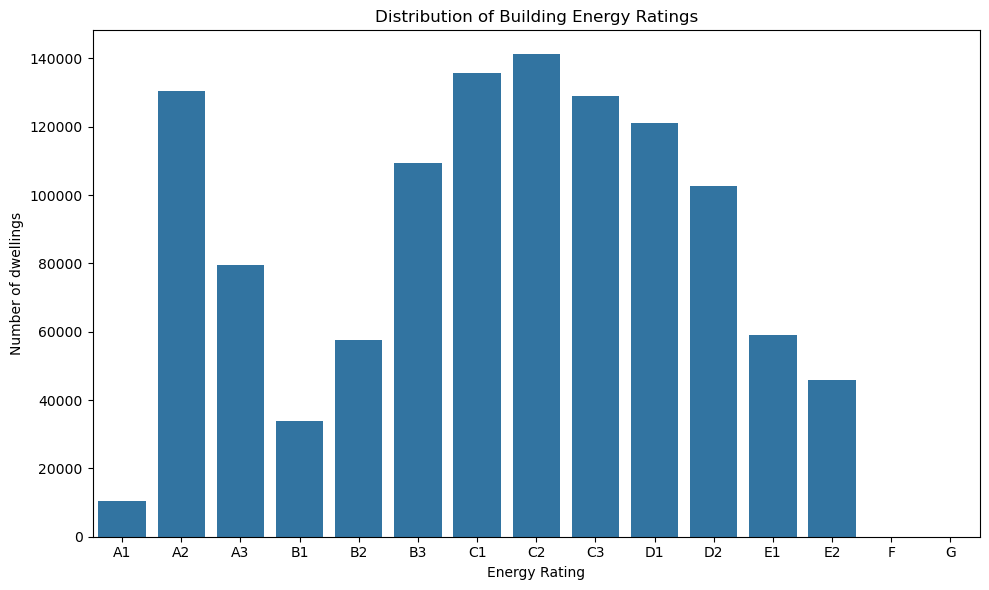

In [61]:
counts = (
    df_eda[ENERGY_RATING_COL]
    .value_counts()
    .reindex(RATING_ORDER, fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Distribution of Building Energy Ratings")
plt.xlabel("Energy Rating")
plt.ylabel("Number of dwellings")
plt.tight_layout()
plt.savefig("rating_distribution.png", dpi=300)
plt.show()


## Most common rating by county (summary plot)

In [62]:
# --- Count ratings per county ---
counts = (
    df_eda
    .groupby([COUNTY_COL, ENERGY_RATING_COL])
    .size()
    .reset_index(name="freq")
)

# Pick the most common rating for each county (tie-break with RATING_ORDER) ---
order_map = {r: i for i, r in enumerate(RATING_ORDER)}
counts["rating_rank"] = counts[ENERGY_RATING_COL].map(order_map).fillna(len(order_map)).astype(int)

top_by_county = (
    counts
    .sort_values([COUNTY_COL, "freq", "rating_rank"], ascending=[True, False, True])
    .groupby(COUNTY_COL, as_index=False)
    .first()  # after sorting, first row per county is the winner
)

# sort counties alphabetically for the plot
top_by_county = top_by_county.sort_values(COUNTY_COL)

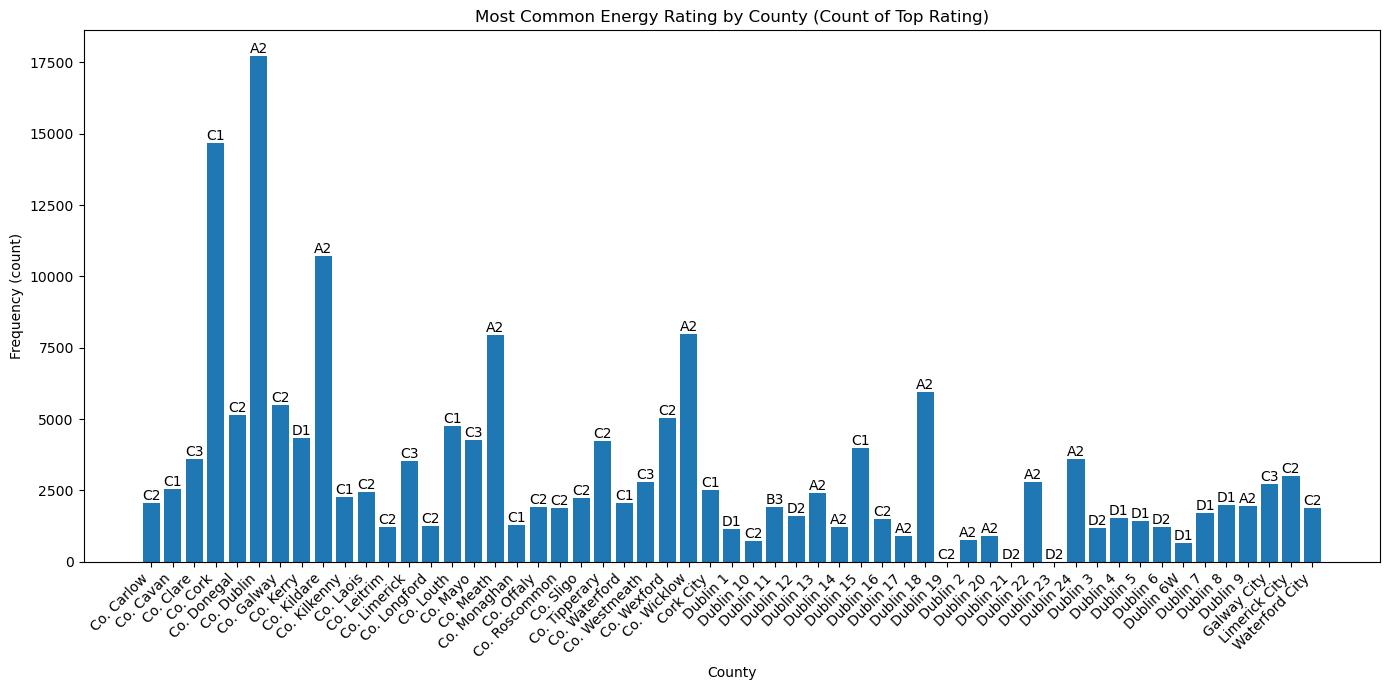

In [63]:
plt.figure(figsize=(14, 7))
bars = plt.bar(top_by_county[COUNTY_COL], top_by_county["freq"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("County")
plt.ylabel("Frequency (count)")
plt.title("Most Common Energy Rating by County (Count of Top Rating)")

# Each bar with the winning rating label
for bar, label in zip(bars, top_by_county[ENERGY_RATING_COL]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(label), ha="center", va="bottom")

plt.tight_layout()
plt.savefig("most_common_rating_by_county.png", dpi=300)
plt.show()

## Rating distribution by construction period (stacked % bars)

In [64]:
df_eda["YearBin"] = pd.cut(
    df_eda[YEAR_COL],
    bins=YEAR_EDGES,
    labels=YEAR_BIN_LABELS,
    right=True,
    include_lowest=False
)

# Keep rows with a valid bin
df_year = df_eda[df_eda["YearBin"].notna()].copy()

In [65]:
# counts per bin by rating 
counts_by_bin = (
    df_year
    .pivot_table(index="YearBin", columns=ENERGY_RATING_COL, aggfunc="size", fill_value=0)
    .reindex(index=YEAR_BIN_LABELS, columns=RATING_ORDER, fill_value=0)
)

# Convert to percentages ---
row_sums = counts_by_bin.sum(axis=1).replace(0, np.nan)
percent_by_bin = (counts_by_bin.div(row_sums, axis=0).fillna(0) * 100)


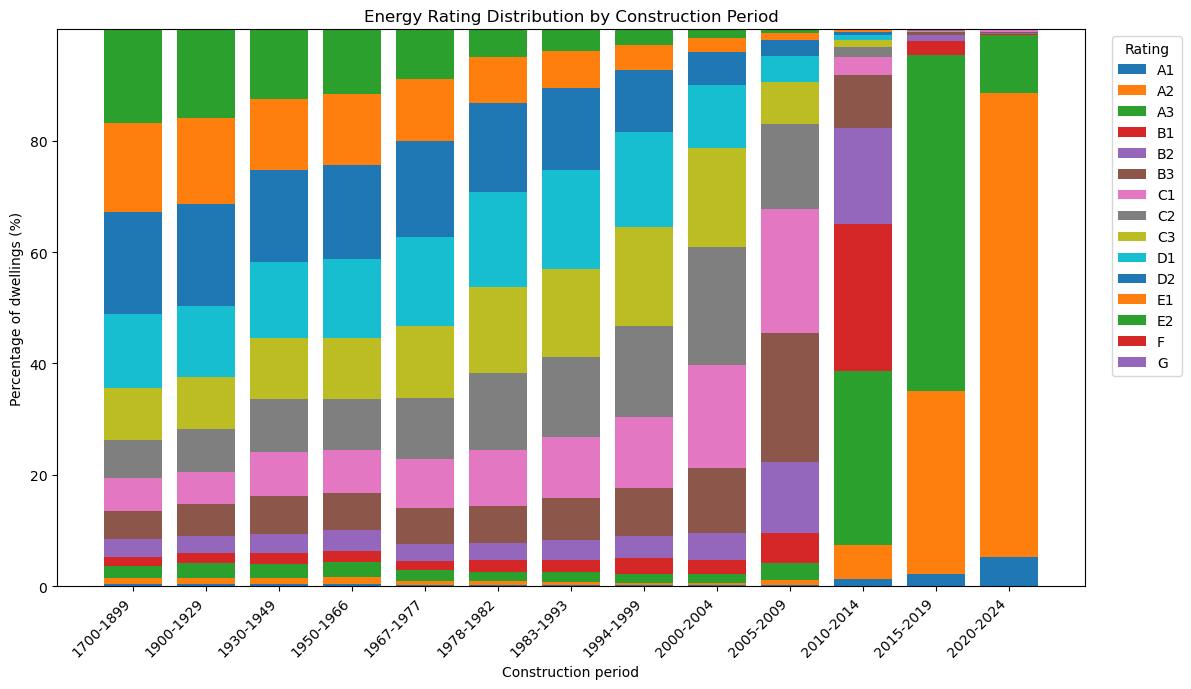

In [66]:
plt.figure(figsize=(12, 7))

bottom = np.zeros(len(percent_by_bin), dtype=float)
for rating in RATING_ORDER:
    heights = percent_by_bin[rating].values
    plt.bar(percent_by_bin.index.astype(str), heights, bottom=bottom, label=rating)
    bottom += heights

plt.xticks(rotation=45, ha="right")
plt.title("Energy Rating Distribution by Construction Period")
plt.xlabel("Construction period")
plt.ylabel("Percentage of dwellings (%)")
plt.legend(title="Rating", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
# plt.savefig("rating_distribution_by_yearbin.png", dpi=300)
plt.show()

## Heating fuel vs. CO₂ emissions

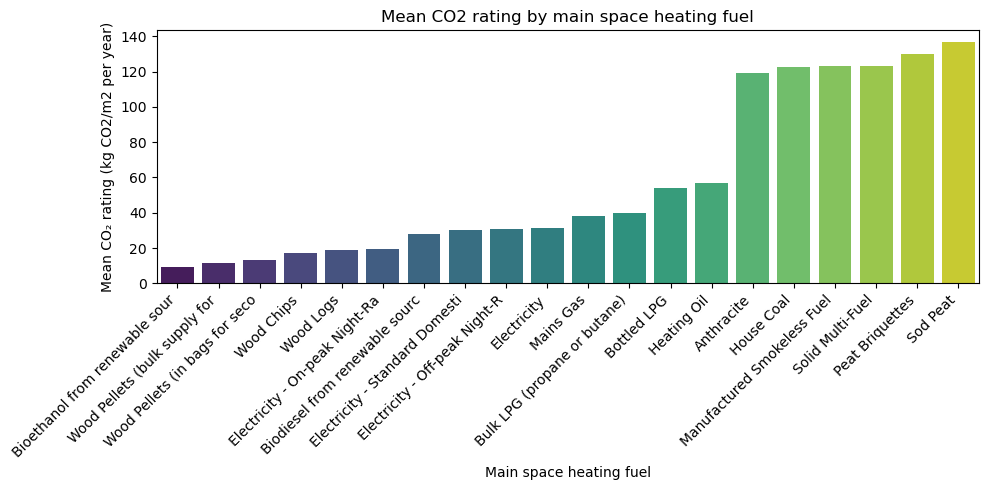

In [67]:
# compute mean CO₂ rating by heating fuel
fuel_co2_means = (df
                  .groupby('MainSpaceHeatingFuel')['CO2Rating']
                  .mean()
                  .sort_values())

# plot the results
plt.figure(figsize=(10, 5))
sns.barplot(
    x=fuel_co2_means.index,
    y=fuel_co2_means.values,
    palette='viridis'
)
plt.title('Mean CO2 rating by main space heating fuel')
plt.xlabel('Main space heating fuel')
plt.ylabel('Mean CO₂ rating (kg CO2/m2 per year)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


-- AI usage for making plots aesthetic 

## Standard Random Forest Regressor and simple imputer with no feature engineering

In [68]:
df = pd.read_csv("Thesis_Data_2_Reduced.csv")

In [70]:
RAW_INPUT_FEATURES: List[str] = [
    "DwellingTypeDescr", "Year_of_Construction",
    "GroundFloorArea(sq m)", "WallArea", "RoofArea", "FloorArea",
    "WindowArea", "DoorArea", "NoStoreys",
    "MainSpaceHeatingFuel", "MainWaterHeatingFuel",
    "InsulationType", "InsulationThickness",
    "VentilationMethod", "PermeabilityTestResult",
    "HeatSystemControlCat", "HeatSystemResponseCat",
    "ThermalMassCategory", "LowEnergyLightingPercent",
    "SHRenewableResources", "WHRenewableResources",
    "SolarHotWaterHeating", "SolarSpaceHeatingSystem",
    "NoOfChimneys", "NoOfOpenFlues",
    "NoOfFansAndVents", "NoOfFluelessGasFires",
    "DraftLobby", "PercentageDraughtStripped",
]

TARGET_COLUMNS: List[str] = [
    "BerRating", "CO2Rating",
    "UValueWall", "UValueRoof", "UValueFloor",
    "UValueWindow", "UvalueDoor",
]

In [128]:
RF_PARAMS = dict(
    n_estimators=100,  
    random_state=42,
    n_jobs=-1,
    max_depth=2,            
    min_samples_leaf=1,     
    bootstrap=True,         
)



In [129]:
def build_preprocessor(X: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    """Numerics -> median impute; Categoricals -> most_frequent + OHE."""
    # figure out which columns are numeric vs categorical
    # (this helps us decide which preprocessing steps to apply)
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    # simple numeric pipeline:
    # - fill missing numeric values with the median (robust to outliers)
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ])

    # sklearn >= 1.2 uses `sparse_output`; older ones use `sparse`.

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    # simple categorical pipeline:
    # 1) impute most frequent category (mode) so we don't drop rows
    # 2) one-hot encode to turn categories into numeric columns
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ])

    # combine both pipelines:
    # - apply numeric_transformer to numeric_cols
    # - apply categorical_transformer to categorical_cols
    # remainder="drop" means: if a column isn't listed above, drop it (shouldn't happen)
    # sparse_threshold=0.3 controls when the combined output is sparse vs dense
    # (we keep it at 0.3 to usually return dense arrays after OHE)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3,
    )

    # return the fitted schema (not fitted on data yet) and the column lists
    # returning the lists is handy for debugging or building feature name maps later
    return preprocessor, numeric_cols, categorical_cols


In [73]:
def train_models(
    df: pd.DataFrame,
    raw_features: List[str] = RAW_INPUT_FEATURES,
    targets: List[str] = TARGET_COLUMNS,
    test_size: float = 0.2,
    random_state: int = 42,
) -> Tuple[Pipeline, Dict[str, Dict[str, float]], pd.DataFrame, pd.DataFrame]:

    X = df[raw_features].copy()
    y = df[targets].copy()

    # standard train/test split for a fair evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # build the preprocessing pipeline:
    preprocessor, _, _ = build_preprocessor(X)

    # wrap RandomForestRegressor in MultiOutputRegressor so we can
    # learn one forest per target column (parallel multi-target setup)
    reg_model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", MultiOutputRegressor(RandomForestRegressor(**RF_PARAMS), n_jobs=1)),
    ])

    # fit the whole pipeline on training data (preprocessor learns imputers/OHE on train only)
    reg_model.fit(X_train, y_train)


    y_pred = reg_model.predict(X_test)


    metrics: Dict[str, Dict[str, float]] = {}
    for idx, col in enumerate(y.columns):
        mae = float(mean_absolute_error(y_test.iloc[:, idx], y_pred[:, idx]))

        rmse = float(np.sqrt(((y_test.iloc[:, idx] - y_pred[:, idx])**2).mean()))
        r2 = float(r2_score(y_test.iloc[:, idx], y_pred[:, idx]))
        metrics[col] = {"MAE": mae, "RMSE": rmse, "R2": r2}


    y_pred_df = pd.DataFrame(y_pred, columns=targets, index=y_test.index)

    return reg_model, metrics, y_test, y_pred_df


In [74]:
# def predict_single(
#     reg_model: Pipeline,
#     user_input: Dict[str, Any],
#     raw_features: List[str] = RAW_INPUT_FEATURES,
#     targets: List[str] = TARGET_COLUMNS,
# ) -> Dict[str, float]:
#     """
#     Predict for one input dict containing raw features only.
#     Missing fields are set to NaN and imputed by the pipeline.
#     """
#     row = {f: user_input.get(f, np.nan) for f in raw_features}
#     X_new = pd.DataFrame([row], columns=raw_features)
#     preds = reg_model.predict(X_new)[0]
#     return {targets[i]: float(preds[i]) for i in range(len(targets))}


In [75]:
reg_model, metrics, y_test, y_pred = train_models(
    df, test_size=0.2, random_state=42
)

# Neat display of metrics
metrics_df = pd.DataFrame(metrics).T[["MAE", "RMSE", "R2"]].sort_values("R2", ascending=False)
metrics_df

,MAE,RMSE,R2
UvalueDoor,0.387255,0.576346,0.705391
UValueFloor,0.104144,0.144618,0.647972
UValueWall,0.249317,0.377850,0.493284
BerRating,60.612524,88.782620,0.465348
UValueWindow,0.382405,0.612793,0.451971
CO2Rating,16.374210,24.055436,0.429109
UValueRoof,0.206128,0.379533,0.307116


## Standard Random Forest Regressor and simple imputer with feature engineering

In [76]:
df = pd.read_csv("Thesis_Data_2_Reduced.csv")

In [77]:
RF_PARAMS = dict(
    n_estimators=200,  
    random_state=42,
    n_jobs=-1,
    max_depth=5,          
    min_samples_split=100,   
    min_samples_leaf=5,     
    bootstrap=True,         
)

In [78]:
reg_model_fe, metrics_fe, y_test_fe, y_pred_fe = train_models(
    df, test_size=0.2, random_state=42
)

metrics_new_2 = (
    pd.DataFrame(metrics_fe)
    .T[["MAE", "RMSE", "R2"]]
    .sort_values("R2", ascending=False)
)
metrics_new_2

,MAE,RMSE,R2
UValueFloor,0.057724,0.106847,0.807841
UvalueDoor,0.277104,0.466503,0.806986
BerRating,46.655173,71.154166,0.656587
CO2Rating,11.979403,18.854901,0.649268
UValueWindow,0.355340,0.532892,0.585567
UValueWall,0.220418,0.347877,0.570484
UValueRoof,0.185914,0.361066,0.372904


In [79]:
models = {
    "v1": metrics_df,        # baseline
    "v2": metrics_new_2,    # (FE run)
}

order_cols = ["MAE", "RMSE", "R2"]

wide = pd.concat(
    {name: m[order_cols] for name, m in models.items()},
    axis=1
)

wide

v1                              v2                     
                    MAE       RMSE        R2        MAE       RMSE        R2
UvalueDoor     0.387255   0.576346  0.705391   0.277104   0.466503  0.806986
UValueFloor    0.104144   0.144618  0.647972   0.057724   0.106847  0.807841
UValueWall     0.249317   0.377850  0.493284   0.220418   0.347877  0.570484
BerRating     60.612524  88.782620  0.465348  46.655173  71.154166  0.656587
UValueWindow   0.382405   0.612793  0.451971   0.355340   0.532892  0.585567
CO2Rating     16.374210  24.055436  0.429109  11.979403  18.854901  0.649268
UValueRoof     0.206128   0.379533  0.307116   0.185914   0.361066  0.372904

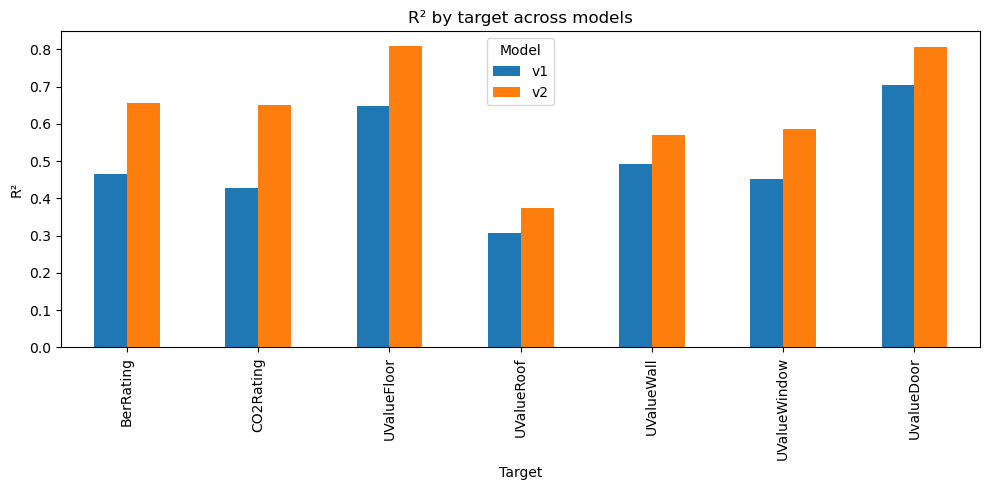

In [80]:
# Long format for plotting
plot_long = (
    wide.stack(0)  # index: target, model ; columns: MAE, RMSE, R2
    .reset_index()
    .rename(columns={"level_1": "Model", "level_0": "Target"})
)

# R² comparison
pivot_r2 = plot_long.pivot(index="Target", columns="Model", values="R2")
ax = pivot_r2.plot(kind="bar", figsize=(10, 5))
plt.title("R² by target across models")
plt.ylabel("R²")
plt.xlabel("Target")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


## Light GBM Regressor and simple imputer with feature engineering

In [130]:
df = pd.read_csv("Thesis_Data_2_reduced.csv")

In [82]:
df_fe = df

In [83]:
FEATURE_DF = df_fe 

FEATURE_COLUMNS: List[str] = [c for c in FEATURE_DF.columns if c not in TARGET_COLUMNS]

# LightGBM params (tweak as needed)
LGBM_REG_PARAMS = dict(
    n_estimators=50,
    learning_rate=0.5,
    num_leaves=2,
    min_child_samples=20,
    subsample=1,
    colsample_bytree=1,
    reg_alpha=2.0,
    reg_lambda=2.0,
    n_jobs=-1,
    verbosity=-1,
    force_col_wise=True,
)


In [84]:
def train_models_lgbm(
    df: pd.DataFrame,
    feature_cols: List[str],
    targets: List[str] = TARGET_COLUMNS,
    test_size: float = 0.2,
    random_state: int = 42,
) -> Tuple[Pipeline, Dict[str, Dict[str, float]], pd.DataFrame, pd.DataFrame]:
    X = df[feature_cols].copy()
    y = df[targets].copy()

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state)

    pre, _, _ = build_preprocessor(X)

    model = Pipeline(steps=[
        ("preprocessor", pre),
        ("model", MultiOutputRegressor(LGBMRegressor(**LGBM_REG_PARAMS), n_jobs=1)),
    ])

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    metrics: Dict[str, Dict[str, float]] = {}
    for i, col in enumerate(y.columns):
        metrics[col] = {
            "MAE": float(mean_absolute_error(y_te.iloc[:, i], y_hat[:, i])),
            "RMSE": float(np.sqrt(mean_squared_error(y_te.iloc[:, i], y_hat[:, i]))),
            "R2": float(r2_score(y_te.iloc[:, i], y_hat[:, i])),
        }

    y_hat_df = pd.DataFrame(y_hat, columns=targets, index=y_te.index)
    return model, metrics, y_te, y_hat_df


In [85]:
reg_model_lgbm, metrics_lgbm, y_test_lgbm, y_pred_lgbm = train_models_lgbm(
    FEATURE_DF,
    feature_cols=FEATURE_COLUMNS,
    test_size=0.2,
    random_state=42,
)

metrics_lgbm_df = (
    pd.DataFrame(metrics_lgbm)
    .T[["MAE", "RMSE", "R2"]]
    .sort_values("R2", ascending=False)
)
metrics_lgbm_df


,MAE,RMSE,R2
BerRating,20.240288,29.791575,0.939799
CO2Rating,6.195053,9.186852,0.916735
UValueFloor,0.070822,0.112008,0.788830
UvalueDoor,0.375326,0.518769,0.761313
UValueWall,0.214011,0.317548,0.642112
UValueWindow,0.375262,0.537142,0.578930
UValueRoof,0.181870,0.327372,0.484480


In [86]:
comparison_two = pd.concat(
    {
        "RF_v3_new2": metrics_new_2[["MAE", "RMSE", "R2"]],
        "LGBM_FE":    metrics_lgbm_df[["MAE", "RMSE", "R2"]],
    },
    axis=1
)

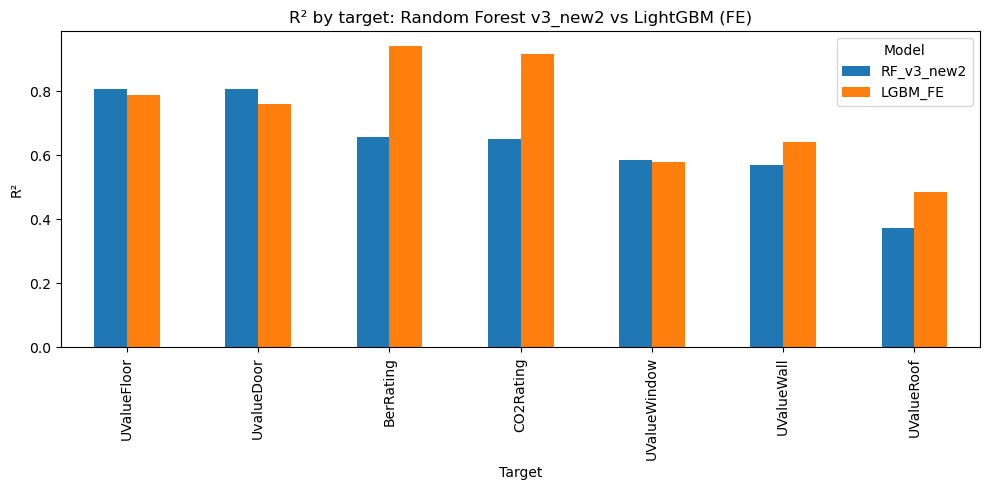

In [87]:
r2_plot = comparison_two.loc[:, [("RF_v3_new2", "R2"), ("LGBM_FE", "R2")]]
r2_plot.columns = ["RF_v3_new2", "LGBM_FE"]

ax = r2_plot.plot(kind="bar", figsize=(10, 5))
plt.title("R² by target: Random Forest v3_new2 vs LightGBM (FE)")
plt.ylabel("R²")
plt.xlabel("Target")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

#### Sources
- https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html
- https://www.kaggle.com/code/mdshahbazalam/lgbm-multioutputregressor

## HyperParameter Tuning LGBM

In [88]:
# data_path = "random_500_rows.csv"  # adjust the path if necessary
# df = pd.read_csv(data_path)

# df_fe = engineer_features(df)
# feature_cols = RAW_INPUT_FEATURES + ENGINEERED_FEATURES
# X = df_fe[feature_cols]
# y = df[TARGET_COLUMNS]

# # ----------------------------
# # 3. Build the preprocessing and modelling pipeline
# # ----------------------------

# preprocessor = build_preprocessor(X)

# # Multi-output regression wrapper around LightGBM
# lgbm_base = LGBMRegressor(boosting_type="gbdt", objective="regression", n_jobs=-1)

# model = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", MultiOutputRegressor(lgbm_base, n_jobs=1))
# ])

# # ----------------------------
# # 4. Define hyperparameter search space
# #    (num_leaves, learning_rate, n_estimators etc. are key parameters to tune:contentReference[oaicite:3]{index=3})
# # ----------------------------

# param_distributions = {
#     # number of boosting iterations (trees)
#     "model__estimator__n_estimators": [200, 400, 600, 800],
#     # learning rate controls how quickly the model learns
#     "model__estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
#     # complexity of each tree: num_leaves should be tuned relative to max_depth:contentReference[oaicite:4]{index=4}
#     "model__estimator__num_leaves": [31, 63, 127],
#     # limit maximum depth explicitly; -1 means no limit
#     "model__estimator__max_depth": [-1, 10, 20, 30],
#     # minimum number of samples per leaf (min_child_samples) to avoid over‑fitting:contentReference[oaicite:5]{index=5}
#     "model__estimator__min_child_samples": [20, 50, 100],
#     # row subsampling and column subsampling
#     "model__estimator__subsample": [0.8, 0.9, 1.0],
#     "model__estimator__colsample_bytree": [0.8, 0.9, 1.0],
#     # L1 and L2 regularization
#     "model__estimator__reg_alpha": [0.0, 0.1, 0.5],
#     "model__estimator__reg_lambda": [0.0, 0.1, 0.5],
# }

# # ----------------------------
# # 5. Define a scoring function for multi-output RMSE
# # ----------------------------

# def rmse_metric(y_true, y_pred):
#     """Negative root mean squared error (negated so that higher is better)."""
#     return -np.sqrt(mean_squared_error(y_true, y_pred))

# scoring = make_scorer(rmse_metric)

# # ----------------------------
# # 6. Run randomized search cross-validation
# #    (uses RandomizedSearchCV for efficiency; you could switch to GridSearchCV
# #     with a smaller grid like the example showing num_leaves, learning_rate and n_estimators:contentReference[oaicite:6]{index=6})
# # ----------------------------

# search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_distributions,
#     n_iter=30,              # number of random combinations to try
#     scoring=scoring,
#     cv=3,                   # 3-fold cross-validation
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit the search to data
# search.fit(X, y)

# # Show the best hyperparameters and score
# print("Best hyperparameters found:", search.best_params_)
# print("Best cross-validation score (negative RMSE):", search.best_score_)

# # To get the best model directly
# best_model = search.best_estimator_


## Code block for hyperparameter tuning was generated using AI in order to find the best params 

-- Names have been interchanged for tuned and untuned dae lgbm

## Best Param Light GBM + Denoising Autoencoder

In [133]:
df = pd.read_csv("Thesis_Data_2_reduced.csv")

In [90]:
class AutoencoderImputer(BaseEstimator, TransformerMixin):

    def __init__(
        self,
        hidden_layer_sizes: Tuple[int, ...] = (128, 64, 128),  # encoder/decoder widths
        activation: str = "relu",                              
        max_iter: int = 200,                                   
        random_state: Optional[int] = 42,                      
        mask_prob: float = 0.2,                                # how much noise to add (mask rate)
        learning_rate_init: float = 1e-3,                      # MLP learning rate
        alpha: float = 1e-4,                                   # L2 weight decay
        batch_size: int | str = "auto",                        # minibatch size
        solver: str = "adam",                                  # optimizer
    ) -> None:
        # Save all hyperparameters so sklearn can clone this estimator in Pipelines/GridSearch
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.max_iter = max_iter
        self.random_state = random_state
        self.mask_prob = mask_prob
        self.learning_rate_init = learning_rate_init
        self.alpha = alpha
        self.batch_size = batch_size
        self.solver = solver

    def fit(self, X: pd.DataFrame, y: Any = None) -> "AutoencoderImputer":
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        self.columns_ = list(X.columns)                  # remember feature order
        self.medians_ = X.median(skipna=True).values     # per-column median for fallback

        # 1) Create a fully-filled version using medians (training target)
        X_filled = X.copy()
        for i, col in enumerate(self.columns_):
            X_filled[col] = X_filled[col].fillna(self.medians_[i])

        # 2) Build a mask of original missing values, then add random masks for denoising
        orig_missing_mask = X.isna().values                             # True where NaN
        rng = np.random.RandomState(self.random_state)
        random_mask = rng.rand(*X_filled.shape) < self.mask_prob        # random hide
        combined_mask = orig_missing_mask | random_mask                 # union of both

        # 3) Make a noisy input: replace masked entries with the column median
        X_noisy = X_filled.to_numpy(dtype=float)                        # ensure numeric float
        medians_arr = self.medians_.reshape((1, -1))
        mask_idx = np.where(combined_mask)                              # (row_idx, col_idx)
        X_noisy[mask_idx] = medians_arr[0, mask_idx[1]]                 # inject noise

        # 4) Concatenate mask flags as extra features so the MLP knows what's missing
        mask_features = combined_mask.astype(float)                     # 1.0 if masked else 0.0
        X_input = np.concatenate([X_noisy, mask_features], axis=1)      # shape: (n, d + d)
        y_target = X_filled.values                                      

        # 5) Train the MLP to reconstruct the clean features from the noisy+mask input
        self.mlp_ = MLPRegressor(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation=self.activation,
            random_state=self.random_state,
            max_iter=self.max_iter,
            learning_rate_init=self.learning_rate_init,
            alpha=self.alpha,
            batch_size=self.batch_size,
            solver=self.solver,
        )
        self.mlp_.fit(X_input, y_target)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if not hasattr(self, "mlp_"):
            raise RuntimeError("AutoencoderImputer has not been fitted yet.")

        # Convert input to DataFrame and align columns like during fit
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns_)
        else:
            X = X.copy()

        # 1) Make a filled copy (medians) so the MLP always receives a complete matrix
        X_filled = X.copy()
        for i, col in enumerate(self.columns_):
            X_filled[col] = X_filled[col].fillna(self.medians_[i])

        # 2) Build a mask of *current* missing values 
        missing_mask = X.isna().values.astype(float)

        X_input = np.concatenate([X_filled.values, missing_mask], axis=1)

 
        reconstructed = self.mlp_.predict(X_input)

        X_out = X.copy()
        for i, col in enumerate(self.columns_):
            mask = X_out[col].isna()                # True where we should fill
            if mask.any():
                X_out.loc[mask, col] = reconstructed[mask.values, i]
        return X_out


In [91]:
def build_preprocessor_with_dae(
    X: pd.DataFrame,
    dae_imputer_params: Optional[Dict[str, Any]] = None,
    sparse_threshold: float = 0.3,
) -> Tuple[ColumnTransformer, List[str], List[str]]:
    
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    num_tf = Pipeline([
        ("imputer", AutoencoderImputer(**(dae_imputer_params or {}))) # Changed from Simple Imputer to DAE
    ])

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_tf, numeric_cols),
            ("cat", cat_tf, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=sparse_threshold,
    )
    return pre, numeric_cols, categorical_cols

In [92]:
def train_models_dae_lgbm(
    df: pd.DataFrame,
    targets: List[str],
    feature_cols: Optional[List[str]] = None,
    *,
    lgbm_params: Dict[str, Any],          # <- REQUIRED
    test_size: float = 0.2,
    random_state: int = 42,
    dae_imputer_params: Optional[Dict[str, Any]] = None,
):

    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in targets]

    X = df[feature_cols].copy()
    y = df[targets].copy()

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    pre, _, _ = build_preprocessor_with_dae(X, dae_imputer_params=dae_imputer_params)

    model = Pipeline(steps=[
        ("preprocessor", pre),
        ("model", MultiOutputRegressor(LGBMRegressor(**lgbm_params), n_jobs=1)),
    ])

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    metrics = {}
    for i, col in enumerate(y.columns):
        mae = float(mean_absolute_error(y_te.iloc[:, i], y_hat[:, i]))
        rmse = float(np.sqrt(mean_squared_error(y_te.iloc[:, i], y_hat[:, i])))
        r2 = float(r2_score(y_te.iloc[:, i], y_hat[:, i]))
        metrics[col] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    y_hat_df = pd.DataFrame(y_hat, columns=targets, index=y_te.index)
    return model, metrics, y_te, y_hat_df

In [93]:
DAE_DEFAULT = dict(  
    hidden_layer_sizes=(128, 64, 32, 64, 128),
    activation="tanh",
    max_iter=200,
    random_state=42,
    mask_prob=0.2,          
    learning_rate_init=2e-4,
    alpha=1e-4,
    batch_size=64,
    solver="adam",
)


In [134]:
LGBM_DEFAULT = dict(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,              # no limit
    min_child_samples=20,
    subsample=1.0,             # a.k.a. bagging_fraction
    reg_alpha=0.0,
    reg_lambda=0.0,
    n_jobs=-1,
    random_state=None,
    verbosity=-1,
)


In [96]:
# Default
reg_model_dae_lgbm_tuned, metrics_dae_lgbm_tuned, y_test_dae_lgbm_tuned, y_pred_dae_lgbm_tuned = train_models_dae_lgbm(
    df,
    targets=TARGET_COLUMNS,
    dae_imputer_params=DAE_DEFAULT,
    lgbm_params=LGBM_DEFAULT,
    test_size=0.2,
    random_state=42,
)

# Metrics table:
pd.DataFrame(metrics_dae_lgbm_tuned).T[["MAE", "RMSE", "R2"]].sort_values("R2", ascending=False)

,MAE,RMSE,R2
BerRating,41.345841,56.389855,0.784316
CO2Rating,11.197394,15.729376,0.755910
UValueFloor,0.095967,0.132519,0.704409
UvalueDoor,0.491841,0.578848,0.702828
UValueWall,0.242482,0.345585,0.576126
UValueWindow,0.410407,0.563992,0.535782
UValueRoof,0.196362,0.353677,0.398305


#### Sources
- https://github.com/ryancheunggit/tabular_dae
- https://github.com/Jinhao510/autoencoder-impute
- https://github.com/Oracen-zz/MIDAS

## HyperParameter Tuning for DAE

In [97]:
# import numpy as np
# import pandas as pd
# from pathlib import Path

# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.multioutput import MultiOutputRegressor

# from lightgbm import LGBMRegressor

# # ----------------------------------------------------------------------
# # 1. Load your data and engineer additional features
# # ----------------------------------------------------------------------
# # This assumes your earlier definitions of RAW_INPUT_FEATURES, ENGINEERED_FEATURES,
# # TARGET_COLUMNS, and the engineer_features function are available in the notebook.
# # If not, copy those definitions here.
# data_path = Path("BER_1kUncleaned_Data.csv")
# df = pd.read_csv(data_path)

# # Engineer extra features (AgeOfHouse, categories, ratios, etc.).
# df_fe = engineer_features(df.copy())
# feature_cols = RAW_INPUT_FEATURES + ENGINEERED_FEATURES

# X = df_fe[feature_cols]
# y = df[TARGET_COLUMNS]

# # ----------------------------------------------------------------------
# # 2. Build preprocessing pipeline
# # ----------------------------------------------------------------------
# # Identify numeric and categorical columns
# numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
# categorical_cols = [c for c in X.columns if c not in numeric_cols]

# # Create one-hot encoder (with dense output for pandas compatibility)
# try:
#     ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# except TypeError:
#     # older versions of scikit-learn use 'sparse'
#     ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# # Build the ColumnTransformer using the AutoencoderImputer for numeric data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", Pipeline(steps=[
#             ("imputer", AutoencoderImputer())
#         ]), numeric_cols),
#         ("cat", Pipeline(steps=[
#             ("imputer", SimpleImputer(strategy="most_frequent")),
#             ("onehot", ohe)
#         ]), categorical_cols)
#     ],
#     remainder="drop",
#     sparse_threshold=0.3,
# )

# # ----------------------------------------------------------------------
# # 3. Build full modelling pipeline
# # ----------------------------------------------------------------------
# # LightGBM hyper‑parameters are assumed already tuned and fixed here
# lgbm_model = LGBMRegressor(**LGBM_REG_PARAMS)
# multi_output_model = MultiOutputRegressor(lgbm_model, n_jobs=1)

# pipeline = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", multi_output_model)
# ])

# # ----------------------------------------------------------------------
# # 4. Define the hyper‑parameter search space for AutoencoderImputer
# # ----------------------------------------------------------------------
# # Tune only the imputer – e.g. hidden layer sizes, activation function,
# # max epochs (max_iter) and the fraction of randomly masked values (mask_prob).
# param_distributions = {
#     "preprocessor__num__imputer__hidden_layer_sizes": [
#         (32,), (64,), (32, 16, 32), (64, 32, 64), (128, 64, 128)
#     ],
#     "preprocessor__num__imputer__activation": [
#         "relu", "tanh"
#     ],
#     "preprocessor__num__imputer__max_iter": [
#         100, 200, 300
#     ],
#     "preprocessor__num__imputer__mask_prob": [
#         0.05, 0.1, 0.2
#     ],
# }

# # ----------------------------------------------------------------------
# # 5. Define a custom multi‑output RMSE scorer
# # ----------------------------------------------------------------------
# # This scorer returns the mean RMSE across all target variables (lower is better).
# def multioutput_rmse(y_true, y_pred):
#     # Compute per‑target MSE, take the square root, then average
#     return float(np.mean(np.sqrt(np.mean((y_pred - y_true) ** 2, axis=0))))

# scorer = make_scorer(multioutput_rmse, greater_is_better=False)

# # ----------------------------------------------------------------------
# # 6. Perform the hyper‑parameter search
# # ----------------------------------------------------------------------
# # Adjust n_iter to control how many random combinations to evaluate.
# # More iterations will give a better chance of finding a good set of parameters.
# search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_distributions,
#     n_iter=10,              # number of parameter sets to sample
#     scoring=scorer,
#     cv=3,                   # 3‑fold cross‑validation
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# # Fit the search object to the data (this may take some time)
# search.fit(X, y)

# # Retrieve best parameters and corresponding score
# print("Best Autoencoder parameters:", search.best_params_)
# print("Best cross‑validated (negative) RMSE score:", search.best_score_)

# # The best estimator can now be accessed via search.best_estimator_
# best_regressor = search.best_estimator_


## Code block for hyperparameter tuning was generated using AI in order to find the best params 

In [136]:
DAE_TUNED = dict(  
    hidden_layer_sizes=(64, 32, 64),
    activation="relu",
    max_iter=200,
    random_state=42,
    mask_prob=0.2,
    learning_rate_init=1e-3,
    alpha=1e-4,
    batch_size="auto",
    solver="adam",
)

LGBM_TUNED = dict(
    n_estimators=600,
    learning_rate=0.01,
    num_leaves=63,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    max_depth=-1,
    n_jobs=-1,
    verbosity=-1,
    force_col_wise=True,
)

In [101]:
# Tuned
reg_model_dae_lgbm, metrics_dae_lgbm, y_test_dae_lgbm, y_pred_dae_lgbm = train_models_dae_lgbm(
    df,
    targets=TARGET_COLUMNS,
    dae_imputer_params=DAE_DEFAULT,
    lgbm_params=LGBM_TUNED,
    test_size=0.2,
    random_state=42,
)
pd.DataFrame(metrics_dae_lgbm).T[["MAE", "RMSE", "R2"]].sort_values("R2", ascending=False)

,MAE,RMSE,R2
BerRating,9.487197,16.887908,0.980655
CO2Rating,3.173957,5.988378,0.964621
UValueFloor,0.046717,0.086908,0.872868
UvalueDoor,0.258406,0.439782,0.828465
UValueWall,0.157980,0.257833,0.764059
UValueWindow,0.332335,0.482916,0.659655
UValueRoof,0.156502,0.314049,0.525588


In [102]:
def as_metrics_df(m):
    if isinstance(m, pd.DataFrame):
        df = m.copy()
    else:                        # dict-of-dicts (target -> {MAE, RMSE, R2}) or similar
        df = pd.DataFrame(m).T
    return df.loc[:, ["MAE", "RMSE", "R2"]]

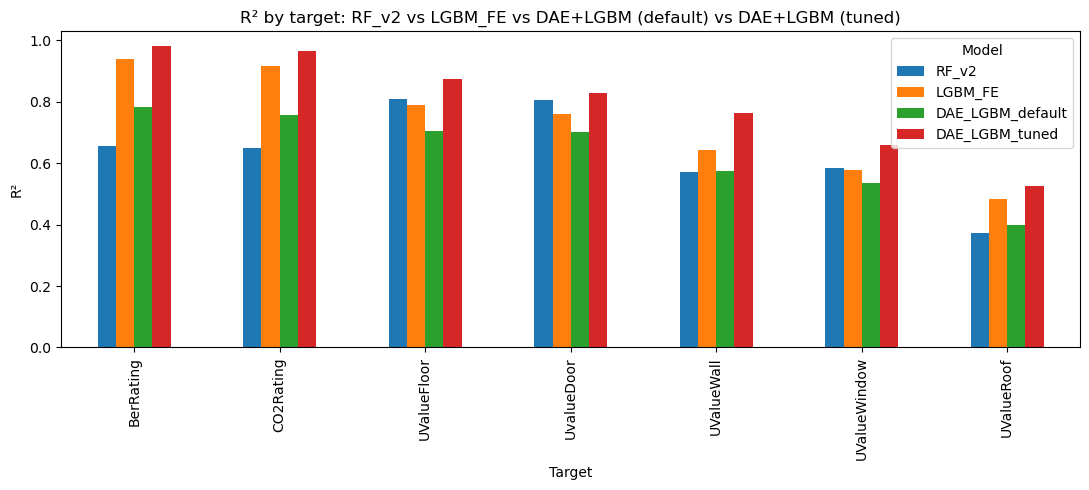

In [103]:
# Build comparable blocks (note: swap default/tuned to match the variable names)
models = {
    "RF_v2":             as_metrics_df(metrics_new_2),
    "LGBM_FE":           as_metrics_df(metrics_lgbm_df),
    "DAE_LGBM_default":  as_metrics_df(metrics_dae_lgbm_tuned),         # default run
    "DAE_LGBM_tuned":    as_metrics_df(metrics_dae_lgbm),   # tuned run
}

# Wide MultiIndex table
wide = pd.concat(models, axis=1)
wide.columns.names = ["Model", "Metric"]

# (Optional) sort rows by the tuned model's R2
if ("DAE_LGBM_tuned", "R2") in wide.columns:
    wide = wide.sort_values(("DAE_LGBM_tuned", "R2"), ascending=False)

# Slice R2 for plotting, keep a specific column order
r2_plot = wide.xs("R2", axis=1, level="Metric").reindex(
    ["RF_v2", "LGBM_FE", "DAE_LGBM_default", "DAE_LGBM_tuned"], axis=1
)

ax = r2_plot.plot(kind="bar", figsize=(11, 5))
plt.title("R² by target: RF_v2 vs LGBM_FE vs DAE+LGBM (default) vs DAE+LGBM (tuned)")
plt.ylabel("R²")
plt.xlabel("Target")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


## LGBM + DAE + Chained Regressor

In [132]:
df = pd.read_csv("Thesis_Data_2_reduced.csv")

In [137]:
LGBM_REG_PARAMS_CHAIN = dict(
    n_estimators=600,
    learning_rate=0.01,
    num_leaves=63,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    max_depth=-1,
    n_jobs=-1,
    verbosity=-1,
    force_col_wise=True,
)


In [106]:

def train_models_dae_lgbm_chain_tuned(
    df: pd.DataFrame,
    raw_features: List[str],
    targets: List[str],
    test_size: float = 0.2,
    random_state: int = 42,
) -> Tuple[Pipeline, Dict[str, Dict[str, float]], pd.DataFrame, pd.DataFrame]:
    """
    Train a chained LightGBM model with tuned DAE imputer.
    Returns: (pipeline, metrics_dict, y_test_df, y_pred_df)
    """
    X = df[raw_features].copy()
    y = df[targets].copy()

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state)

    pre, _, _ = build_preprocessor_with_dae(X)

    model = Pipeline(steps=[
        ("preprocessor", pre),
        ("model", RegressorChain(LGBMRegressor(**LGBM_REG_PARAMS_CHAIN))),
    ])

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    metrics: Dict[str, Dict[str, float]] = {}
    for i, col in enumerate(y.columns):
        metrics[col] = {
            "MAE": float(mean_absolute_error(y_te.iloc[:, i], y_hat[:, i])),
            "RMSE": float(np.sqrt(((y_te.iloc[:, i] - y_hat[:, i]) ** 2).mean())),
            "R2": float(r2_score(y_te.iloc[:, i], y_hat[:, i])),
        }

    y_hat_df = pd.DataFrame(y_hat, columns=targets, index=y_te.index)
    return model, metrics, y_te, y_hat_df

In [107]:
# ---- Run & store results in NEW variables ----
# Assumes your dataframe is `df` and you already defined RAW_INPUT_FEATURES & TARGET_COLUMNS
reg_model_dae_lgbm_chain_tuned, metrics_dae_lgbm_chain_tuned, y_test_dae_lgbm_chain_tuned, y_pred_dae_lgbm_chain_tuned = \
    train_models_dae_lgbm_chain_tuned(
        df,
        raw_features=RAW_INPUT_FEATURES,
        targets=TARGET_COLUMNS,
        test_size=0.2,
        random_state=42,
    )

metrics_dae_lgbm_chain_tuned_df = (
    pd.DataFrame(metrics_dae_lgbm_chain_tuned)
    .T[["MAE", "RMSE", "R2"]]
    .sort_values("R2", ascending=False)
)

metrics_dae_lgbm_chain_tuned_df  # display

,MAE,RMSE,R2
UValueFloor,0.050003,0.094502,0.849681
CO2Rating,8.012504,12.923933,0.835216
BerRating,34.144920,53.392914,0.806633
UvalueDoor,0.264345,0.480934,0.794860
UValueWindow,0.353163,0.521812,0.602621
UValueWall,0.202607,0.346220,0.574566
UValueRoof,0.173849,0.355446,0.392272


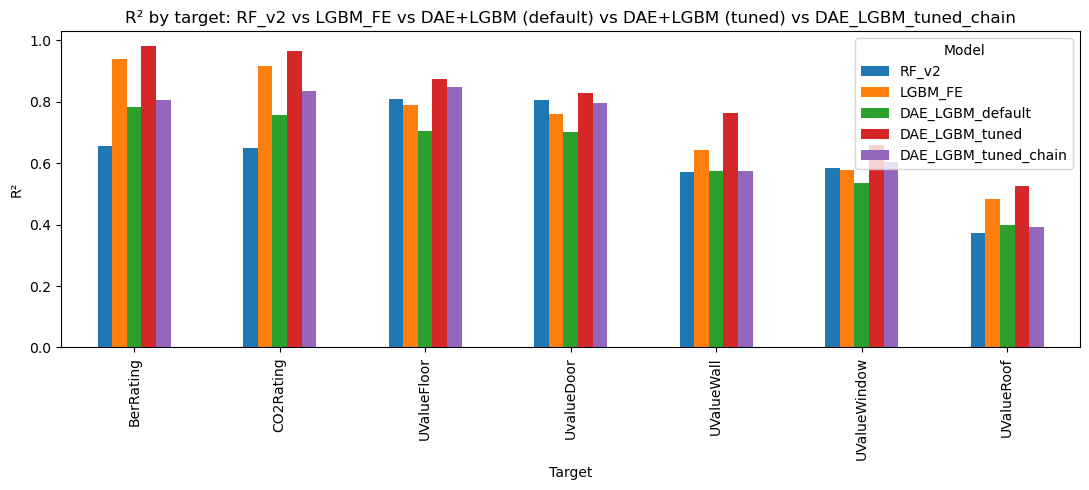

In [108]:
# Build comparable blocks (note: swap default/tuned to match the variable names)
models = {
    "RF_v2":             as_metrics_df(metrics_new_2),
    "LGBM_FE":           as_metrics_df(metrics_lgbm_df),
    "DAE_LGBM_default":  as_metrics_df(metrics_dae_lgbm_tuned),         # default run
    "DAE_LGBM_tuned":    as_metrics_df(metrics_dae_lgbm),
    "DAE_LGBM_tuned_chain": as_metrics_df(metrics_dae_lgbm_chain_tuned_df)# tuned run
}

# Wide MultiIndex table
wide = pd.concat(models, axis=1)
wide.columns.names = ["Model", "Metric"]

# (Optional) sort rows by the tuned model's R2
if ("DAE_LGBM_tuned", "R2") in wide.columns:
    wide = wide.sort_values(("DAE_LGBM_tuned", "R2"), ascending=False)

# Slice R2 for plotting, keep a specific column order
r2_plot = wide.xs("R2", axis=1, level="Metric").reindex(
    ["RF_v2", "LGBM_FE", "DAE_LGBM_default", "DAE_LGBM_tuned","DAE_LGBM_tuned_chain"], axis=1
)

ax = r2_plot.plot(kind="bar", figsize=(11, 5))
plt.title("R² by target: RF_v2 vs LGBM_FE vs DAE+LGBM (default) vs DAE+LGBM (tuned) vs DAE_LGBM_tuned_chain")
plt.ylabel("R²")
plt.xlabel("Target")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


#### Source
https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.RegressorChain.html

In [131]:
df = pd.read_csv("Thesis_Data_2_reduced.csv")

## MICE (Iterative Imputer)

In [110]:
def build_preprocessor_with_mice(X: pd.DataFrame) -> tuple[ColumnTransformer, list, list]:
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    # MICE for numerics (defaults to BayesianRidge as base estimator)
    num_tf = Pipeline([
        ("imputer", IterativeImputer(
            random_state=42,
            max_iter=10,
            initial_strategy="median",
            sample_posterior=False,
        ))
    ])

    # Most-frequent for categoricals, then OHE
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ])

    pre = ColumnTransformer(
        transformers=[("num", num_tf, numeric_cols), ("cat", cat_tf, categorical_cols)],
        remainder="drop",
        sparse_threshold=0.3,
    )
    return pre, numeric_cols, categorical_cols

In [138]:


LGBM_REG_PARAMS_MICE = dict(
    n_estimators=600,
    learning_rate=0.01,
    num_leaves=63,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    max_depth=-1,
    n_jobs=-1,
    verbosity=-1,
    force_col_wise=True,
)


In [112]:
def train_models_mice_lgbm(
    df: pd.DataFrame,
    targets: list = TARGET_COLUMNS,
    feature_cols: list | None = None,
    test_size: float = 0.2,
    random_state: int = 42,
):

    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in targets]

    X = df[feature_cols].copy()
    y = df[targets].copy()

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state)

    pre, _, _ = build_preprocessor_with_mice(X)

    model = Pipeline(steps=[
        ("preprocessor", pre),
        ("model", MultiOutputRegressor(LGBMRegressor(**LGBM_REG_PARAMS_MICE), n_jobs=1)),
    ])

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    metrics = {}
    for i, col in enumerate(y.columns):
        metrics[col] = {
            "MAE": float(mean_absolute_error(y_te.iloc[:, i], y_hat[:, i])),
            "RMSE": float(np.sqrt(((y_te.iloc[:, i] - y_hat[:, i]) ** 2).mean())),
            "R2": float(r2_score(y_te.iloc[:, i], y_hat[:, i])),
        }

    y_hat_df = pd.DataFrame(y_hat, columns=targets, index=y_te.index)
    return model, metrics, y_te, y_hat_df

In [113]:
reg_model_mice_lgbm, metrics_mice_lgbm, y_test_mice_lgbm, y_pred_mice_lgbm = \
    train_models_mice_lgbm(df, test_size=0.2, random_state=42)

metrics_mice_lgbm_df = (
    pd.DataFrame(metrics_mice_lgbm)
    .T[["MAE", "RMSE", "R2"]]
    .sort_values("R2", ascending=False)
)

metrics_mice_lgbm_df  # display

,MAE,RMSE,R2
BerRating,9.548540,17.374990,0.979523
CO2Rating,3.163310,6.026875,0.964165
UValueFloor,0.047439,0.087603,0.870827
UvalueDoor,0.260866,0.441928,0.826786
UValueWall,0.158935,0.258256,0.763283
UValueWindow,0.329907,0.481397,0.661793
UValueRoof,0.155955,0.314747,0.523475


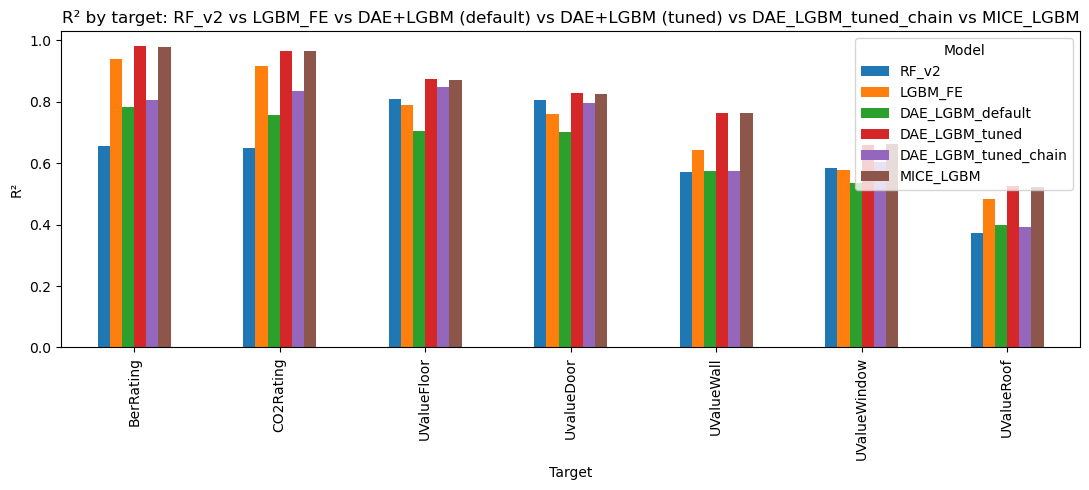

In [114]:
# Build comparable blocks (note: swap default/tuned to match the variable names)
models = {
    "RF_v2":             as_metrics_df(metrics_new_2),
    "LGBM_FE":           as_metrics_df(metrics_lgbm_df),
    "DAE_LGBM_default":  as_metrics_df(metrics_dae_lgbm_tuned),         # default run
    "DAE_LGBM_tuned":    as_metrics_df(metrics_dae_lgbm),
    "DAE_LGBM_tuned_chain": as_metrics_df(metrics_dae_lgbm_chain_tuned_df),
    "MICE_LGBM":     as_metrics_df(metrics_mice_lgbm_df)#tuned run
}

# Wide MultiIndex table
wide = pd.concat(models, axis=1)
wide.columns.names = ["Model", "Metric"]

# (Optional) sort rows by the tuned model's R2
if ("DAE_LGBM_tuned", "R2") in wide.columns:
    wide = wide.sort_values(("DAE_LGBM_tuned", "R2"), ascending=False)

# Slice R2 for plotting, keep a specific column order
r2_plot = wide.xs("R2", axis=1, level="Metric").reindex(
    ["RF_v2", "LGBM_FE", "DAE_LGBM_default", "DAE_LGBM_tuned","DAE_LGBM_tuned_chain","MICE_LGBM"], axis=1
)

ax = r2_plot.plot(kind="bar", figsize=(11, 5))
plt.title("R² by target: RF_v2 vs LGBM_FE vs DAE+LGBM (default) vs DAE+LGBM (tuned) vs DAE_LGBM_tuned_chain vs MICE_LGBM")
plt.ylabel("R²")
plt.xlabel("Target")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


#### Sources
- https://github.com/Ouwen/scikit-mice
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

## MissForest / One Extra Tree MICE

In [115]:
def build_preprocessor_with_mice_tree(X: pd.DataFrame) -> tuple[ColumnTransformer, list, list]:
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    base_estimator = ExtraTreesRegressor(
        n_estimators=100,
        max_depth=12,         # limit tree depth
        max_features=0.6,     # fewer features per split
        min_samples_leaf=5,
        random_state=42,
        n_jobs=1,
    )

    num_tf = Pipeline([
        ("imputer", IterativeImputer(
            estimator=base_estimator,
            max_iter=5,
            n_nearest_features=20,
            initial_strategy="median",
             imputation_order="ascending",
            sample_posterior=False,
            random_state=42,
        ))
    ])

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ])

    pre = ColumnTransformer(
        transformers=[("num", num_tf, numeric_cols), ("cat", cat_tf, categorical_cols)],
        remainder="drop",
        sparse_threshold=0.3,
    )
    return pre, numeric_cols, categorical_cols

In [139]:


LGBM_REG_PARAMS_MICE_TREE = dict(
    n_estimators=600,
    learning_rate=0.01,
    num_leaves=63,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    max_depth=-1,
    n_jobs=-1,
    verbosity=-1,
    force_col_wise=True,
)


In [117]:
def train_models_mice_tree_lgbm(
    df: pd.DataFrame,
    targets: list = TARGET_COLUMNS,
    feature_cols: list | None = None,
    test_size: float = 0.2,
    random_state: int = 42,
):
    """
    MultiOutput LightGBM with tree-based MICE imputation for numeric features.
    Returns: (pipeline, metrics_dict, y_test_df, y_pred_df)
    """
    if feature_cols is None:
        feature_cols = [c for c in df.columns if c not in targets]

    X = df[feature_cols].copy()
    y = df[targets].copy()

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state)

    pre, _, _ = build_preprocessor_with_mice_tree(X)

    model = Pipeline(steps=[
        ("preprocessor", pre),
        ("model", MultiOutputRegressor(LGBMRegressor(**LGBM_REG_PARAMS_MICE_TREE), n_jobs=1)),
    ])

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)

    metrics = {}
    for i, col in enumerate(y.columns):
        metrics[col] = {
            "MAE": float(mean_absolute_error(y_te.iloc[:, i], y_hat[:, i])),
            "RMSE": float(np.sqrt(((y_te.iloc[:, i] - y_hat[:, i]) ** 2).mean())),
            "R2": float(r2_score(y_te.iloc[:, i], y_hat[:, i])),
        }

    y_hat_df = pd.DataFrame(y_hat, columns=targets, index=y_te.index)
    return model, metrics, y_te, y_hat_df

In [118]:
reg_model_mice_tree, metrics_mice_tree, y_test_mice_lgbm, y_pred_mice_lgbm = \
    train_models_mice_tree_lgbm(df, test_size=0.2, random_state=42)

metrics_mice_tree_df = (
    pd.DataFrame(metrics_mice_lgbm)
    .T[["MAE", "RMSE", "R2"]]
    .sort_values("R2", ascending=False)
)

metrics_mice_tree_df

,MAE,RMSE,R2
BerRating,9.548540,17.374990,0.979523
CO2Rating,3.163310,6.026875,0.964165
UValueFloor,0.047439,0.087603,0.870827
UvalueDoor,0.260866,0.441928,0.826786
UValueWall,0.158935,0.258256,0.763283
UValueWindow,0.329907,0.481397,0.661793
UValueRoof,0.155955,0.314747,0.523475


#### Sources
- https://github.com/xbeat/Machine-Learning/blob/main/Advanced%20Handling%20Missing%20Data%20in%20Python.md
- https://www.kaggle.com/code/lmorgan95/missforest-the-best-imputation-algorithm
- https://scikit-learn.org/stable/modules/impute.html

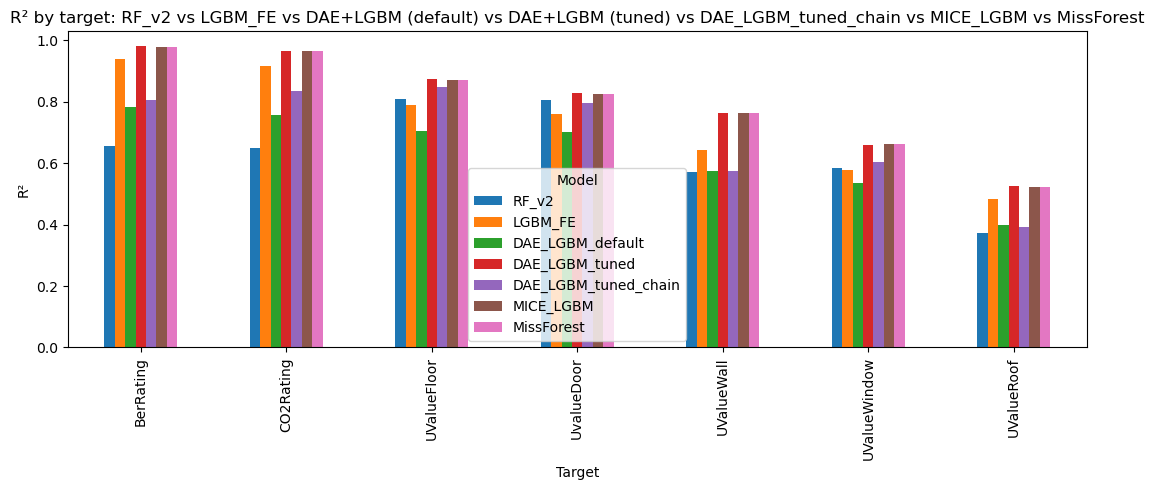

In [119]:
# Build comparable blocks (note: swap default/tuned to match the variable names)
models = {
    "RF_v2":             as_metrics_df(metrics_new_2),
    "LGBM_FE":           as_metrics_df(metrics_lgbm_df),
    "DAE_LGBM_default":  as_metrics_df(metrics_dae_lgbm_tuned),         # default run
    "DAE_LGBM_tuned":    as_metrics_df(metrics_dae_lgbm),
    "DAE_LGBM_tuned_chain": as_metrics_df(metrics_dae_lgbm_chain_tuned_df),
    "MICE_LGBM":     as_metrics_df(metrics_mice_lgbm_df),
    "MissForest": as_metrics_df(metrics_mice_tree_df)
}

# Wide MultiIndex table
wide = pd.concat(models, axis=1)
wide.columns.names = ["Model", "Metric"]

# (Optional) sort rows by the tuned model's R2
if ("DAE_LGBM_tuned", "R2") in wide.columns:
    wide = wide.sort_values(("DAE_LGBM_tuned", "R2"), ascending=False)

# Slice R2 for plotting, keep a specific column order
r2_plot = wide.xs("R2", axis=1, level="Metric").reindex(
    ["RF_v2", "LGBM_FE", "DAE_LGBM_default", "DAE_LGBM_tuned","DAE_LGBM_tuned_chain","MICE_LGBM","MissForest"], axis=1
)

ax = r2_plot.plot(kind="bar", figsize=(11, 5))
plt.title("R² by target: RF_v2 vs LGBM_FE vs DAE+LGBM (default) vs DAE+LGBM (tuned) vs DAE_LGBM_tuned_chain vs MICE_LGBM vs MissForest")
plt.ylabel("R²")
plt.xlabel("Target")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


## Evaluating Imputers
- Used AI to learn code from https://github.com/udellgroup/gcimpute and generate skeleton for this

**AI assistance — Evaluation protocol & masking.** 
- **Extent:** Methods → *Evaluation Protocol* (sampling and preview) and Appendix code (Listing L1: ~Lines 1–96).
- **What AI provided:**  per-persona NaN injection driven by `numpy.random.default_rng(seed_base + i)` with caps (`min(3, …)` numeric, `min(2, …)` categorical); and an audit trail in `mask_records` (including which `RAW_INPUT_FEATURES` are missing).
- **Reason:** Faster design of a deterministic, auditable “imputation-stress” setup that varies masked fields across people without touching targets.
- **Verification:** asserted no `TARGET_COLUMNS` are ever masked; checked NaN counts match selected columns; ensured preview columns exist; confirmed `true_values_list` comes from the *unmasked* row and `example_inputs` contain only `feature_cols`.
- **How incorporated:** Personas/RowIDs cited in Methods; masking logs used in Results discussion; figures report robustness under masked-feature conditions.




In [120]:
num_examples = 50  # treat as 12 different people
seed_base = 12345  # reproducibility for masking choices

df_test = df


# Define feature columns for full-models (all non-target columns)
feature_cols = [c for c in df_test.columns if c not in TARGET_COLUMNS]

# Split by dtype (used only for controlled masking below)
numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_test[c])]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

# ---------------------------------------------------------------------------
# Pick 12 specific rows and keep their original indices for traceability
samples = (
    df_test
    .sample(n=num_examples, random_state=66)   # reproducible selection
    .reset_index()                            # preserve original index
    .rename(columns={"index": "RowID"})       # RowID = original df_test index
)

# Show which rows (people) were selected and a quick preview
preview_cols = [
    # tweak these if you want a different preview subset
    "CountyName", "DwellingTypeDescr", "Year_of_Construction",
    "GroundFloorArea(sq m)", "NoStoreys", "MainSpaceHeatingFuel"
]
print("=== Selected people (sampled rows) with quick preview ===")
print(
    samples[["RowID"] + [c for c in preview_cols if c in df_test.columns]]
    .to_string(index=False)
)

# ---------------------------------------------------------------------------
# Create “imputation-stress” inputs by masking a few numeric & categorical
# features per person; keep an explicit record of exactly which columns were masked
example_inputs = []
true_values_list = []
mask_records = []  # to log which columns were masked for each person

for i, row in samples.iterrows():
    person_id = i + 1
    row_id = int(row["RowID"])

    # The original, unmodified row (drop helper column)
    orig_row = row.drop(labels=["RowID"]).copy()

    # Make a masked copy
    modified_row = orig_row.copy()

    # Choose which columns to set to NaN (reproducible, different per person)
    # Up to 3 numeric + 2 categorical masked per person (adjust if you like)
    n_num_missing = min(3, len(numeric_cols))
    n_cat_missing = min(2, len(categorical_cols))
    rng = np.random.default_rng(seed_base + i)

    num_missing_cols = sorted(rng.choice(numeric_cols, size=n_num_missing, replace=False).tolist()) if n_num_missing else []
    cat_missing_cols = sorted(rng.choice(categorical_cols, size=n_cat_missing, replace=False).tolist()) if n_cat_missing else []

    for col in num_missing_cols + cat_missing_cols:
        modified_row[col] = np.nan

    # Keep only feature columns for model inputs
    example_inputs.append(modified_row[feature_cols].to_dict())

    # Store true targets for error calculation
    true_values_list.append(orig_row[TARGET_COLUMNS])

    # Log the masking choices with actual column names
    mask_records.append({
        "PersonID": person_id,
        "RowID": row_id,
        "MaskedNumericCols": num_missing_cols,
        "MaskedCategoricalCols": cat_missing_cols,
    })

# Print masking details person-by-person (including which RAW_INPUT_FEATURES ended up NaN)
print("\n=== Masking details per person ===")
for rec in mask_records:
    pid = rec["PersonID"]
    rid = rec["RowID"]
    print(f"\nPerson {pid}  (RowID in df_test: {rid})")
    print("  Masked numeric cols:     ", rec["MaskedNumericCols"])
    print("  Masked categorical cols: ", rec["MaskedCategoricalCols"])

    # Which of the RF raw inputs are missing for this person’s input?
    rf_input = {f: example_inputs[pid-1].get(f, np.nan) for f in RAW_INPUT_FEATURES}
    rf_missing = [k for k, v in rf_input.items() if pd.isna(v)]
    print("  Missing among RAW_INPUT_FEATURES (for RF models):", rf_missing)

# ---------------------------------------------------------------------------
# Build a dictionary of models to test (skip any you haven’t trained this run)
model_vars = [
    ("RF_v2", "reg_model_fe"),                          # RandomForest with FE data
    ("LGBM_FE", "reg_model_lgbm"),                         # LightGBM + SimpleImputer
    ("DAE_LGBM_tuned", "reg_model_dae_lgbm"),        # LGBM + tuned DAE
    ("DAE_LGBM_chain_tuned", "reg_model_dae_lgbm_chain_tuned"),  # Chained LGBM + tuned DAE
    ("MissForest_LGBM", "reg_model_mice_tree"),                  # LGBM + MICE
]



models_to_test = {
    label: globals().get(varname) for (label, varname) in model_vars
}
# Drop any that aren't defined
models_to_test = {k: v for k, v in models_to_test.items() if v is not None}

# ---------------------------------------------------------------------------
# Predict and compute errors
results = []
for model_name, model in models_to_test.items():
    for idx, (input_dict, true_vals) in enumerate(zip(example_inputs, true_values_list)):
        # Prepare input for the correct feature space
        if model_name.startswith("RF"):
            # RF models were trained on RAW_INPUT_FEATURES only
            features = {f: input_dict.get(f, np.nan) for f in RAW_INPUT_FEATURES}
            X_input = pd.DataFrame([features])
        else:
            # Other models use the full engineered feature set
            X_input = pd.DataFrame([input_dict], columns=feature_cols)

        # Predict
        pred_vals = model.predict(X_input)[0]

        # Compute errors for each target
        errors = {}
        for i_t, col in enumerate(TARGET_COLUMNS):
            true_val = float(true_vals[col])
            pred_val = float(pred_vals[i_t])
            abs_err = abs(pred_val - true_val)
            sq_err = (pred_val - true_val) ** 2
            rel_err = 100 * abs_err / (true_val if true_val != 0 else 1.0)
            errors[col] = {
                "True": true_val,
                "Pred": pred_val,
                "AbsoluteError": abs_err,
                "SquaredError": sq_err,
                "RelativeError(%)": rel_err,
            }

        results.append({
            "Model": model_name,
            "PersonID": idx + 1,
            "RowID": int(samples.loc[idx, "RowID"]),
            "Errors": errors,
        })

# ---------------------------------------------------------------------------
# Display detailed errors for each model and person
for res in results:
    print(f"\nModel: {res['Model']} | Person {res['PersonID']} (RowID {res['RowID']})")
    pprint.pprint(res["Errors"])

# ---------------------------------------------------------------------------
# Optional: summarise mean absolute error across people for each model and target
mae_summary = {}
for model_name in models_to_test.keys():
    model_rows = [r for r in results if r["Model"] == model_name]
    if not model_rows:
        continue
    mae_summary[model_name] = {
        col: np.mean([r["Errors"][col]["AbsoluteError"] for r in model_rows])
        for col in TARGET_COLUMNS
    }

mae_df = pd.DataFrame(mae_summary).T
print("\n\nMean Absolute Error per model and target across all people:")
print(mae_df)


=== Selected people (sampled rows) with quick preview ===
 RowID    CountyName      DwellingTypeDescr  Year_of_Construction  GroundFloorArea(sq m)  NoStoreys         MainSpaceHeatingFuel
  1048   Co. Donegal   End of terrace house                  1974                  94.03          2                  Heating Oil
  1569      Co. Cork                  House                  1987                  89.47          2                    Mains Gas
  1254     Dublin 12    Top-floor apartment                  2024                  50.36          1                  Electricity
  6136   Co. Donegal         Detached house                  1900                 146.00          2                  Heating Oil
  3034     Co. Kerry Ground-floor apartment                  2002                  51.91          1 Bulk LPG (propane or butane)
  1296    Co. Galway         Detached house                  1890                  73.94          1                  Heating Oil
  2081      Co. Mayo    Semi-detached h

In [121]:
mae_df

,BerRating,CO2Rating,UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor
RF_v2,49.720600,11.586464,0.248341,0.136699,0.059108,0.425836,0.330232
LGBM_FE,23.565080,7.561575,0.234203,0.148949,0.068760,0.395143,0.434207
DAE_LGBM_tuned,13.804498,3.463687,0.146755,0.127597,0.046571,0.320520,0.249862
DAE_LGBM_chain_tuned,30.271105,7.031830,0.177905,0.129531,0.056553,0.367683,0.301226
MissForest_LGBM,13.760822,3.543539,0.137938,0.111625,0.048549,0.293244,0.250144


In [122]:
# === RAW-ONLY IMPUTATION EVAL — scenario variations, no ALL_KNOWN, reuse fitted imputers ===
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any

# --- Preconditions ---
assert "df_test" in globals(), "df_test not found"
assert "RAW_INPUT_FEATURES" in globals(), "RAW_INPUT_FEATURES not found"

# Use only RAW_INPUT_FEATURES present in df_test
EVAL_RAW: List[str] = [c for c in RAW_INPUT_FEATURES if c in df_test.columns]
assert len(EVAL_RAW) > 0, "None of the RAW_INPUT_FEATURES are in df_test."

num_cols_raw = [c for c in EVAL_RAW if pd.api.types.is_numeric_dtype(df_test[c])]
cat_cols_raw = [c for c in EVAL_RAW if c not in num_cols_raw]

# --------- Helper: extract the fitted numeric imputer + its training column list ---------
def extract_fitted_numeric_imputer(fitted_pipeline) -> Tuple[Any, List[str]]:
    pre = fitted_pipeline.named_steps.get("preprocessor", None)
    if pre is None:
        raise ValueError("No 'preprocessor' step in pipeline")

    num_cols_fit, imputer = None, None
    for name, trans, cols in pre.transformers_:
        if name == "num":
            num_cols_fit = list(cols)
            if hasattr(trans, "named_steps") and "imputer" in trans.named_steps:
                imputer = trans.named_steps["imputer"]
            else:
                imputer = trans
            break
    if imputer is None or num_cols_fit is None:
        raise ValueError("Couldn't locate numeric transformer 'num' with an 'imputer'")
    return imputer, num_cols_fit

# --------- Collect fitted imputers from trained pipelines (no refitting) ---------

candidate_pipelines = {
    "Simple_from_LGBM": globals().get("reg_model_lgbm"),
    "DAE_tuned": globals().get("reg_model_dae_lgbm"),
    "DAE_tuned_chain": globals().get("reg_model_dae_lgbm_chain_tuned"),
    "MissForest(Tree)": globals().get("reg_model_mice_tree"),
}
fitted_numeric_imputers: Dict[str, Dict[str, Any]] = {}
for label, pipe in candidate_pipelines.items():
    if pipe is None:
        continue
    try:
        imp, cols = extract_fitted_numeric_imputer(pipe)
        fitted_numeric_imputers[label] = {"imputer": imp, "num_cols_fit": cols}
        print(f"Attached imputer: {label} | type={type(imp).__name__} | n_cols_fit={len(cols)}")
    except Exception as e:
        print(f"Skipping {label}: {e}")
assert len(fitted_numeric_imputers) > 0, "No fitted imputers could be extracted."

# --------- Scenario definitions (no ALL_KNOWN) ---------
CORE_KEYS_ALL = [
    "CountyName", "DwellingTypeDescr", "Year_of_Construction",
    "GroundFloorArea(sq m)", "NoStoreys", "MainSpaceHeatingFuel"
]
CORE_KEYS = [k for k in CORE_KEYS_ALL if k in EVAL_RAW]

def _choose(rng, items, k):
    items = list(items)
    k = max(0, min(k, len(items)))
    if k == 0:
        return []
    return rng.choice(items, size=k, replace=False).tolist()

def build_known_set(row: pd.Series, scenario: str, rng: np.random.Generator) -> set:

    others = [c for c in EVAL_RAW if c not in CORE_KEYS]

    if scenario == "CORE_0_plus_8_others":
        # none of the core fields are known; 8 other RAW known
        return set(_choose(rng, others, min(8, len(others))))

    if scenario == "CORE_2_plus_6_others":
        # 2 core fields known, 6 other RAW known
        return set(_choose(rng, CORE_KEYS, min(2, len(CORE_KEYS)))) | set(_choose(rng, others, min(6, len(others))))

    if scenario == "CORE_4_plus_4_others":
        # 4 core fields known, 4 other RAW known
        return set(_choose(rng, CORE_KEYS, min(4, len(CORE_KEYS)))) | set(_choose(rng, others, min(4, len(others))))

    if scenario == "CORE_partial_only":
        # only a subset (2–3) of core fields known; no other RAW provided
        k = 3 if len(CORE_KEYS) >= 3 else min(2, len(CORE_KEYS))
        return set(_choose(rng, CORE_KEYS, k))

    if scenario == "YEAR_unknown_core_plus_others":
        # Year_of_Construction intentionally unknown; 3 other core + 5 others known
        ks = set(CORE_KEYS) - {"Year_of_Construction"} if "Year_of_Construction" in CORE_KEYS else set(CORE_KEYS)
        known_core = set(_choose(rng, ks, min(3, len(ks))))
        return known_core | set(_choose(rng, others, min(5, len(others))))

    if scenario == "SIZE_unknown_core_plus_others":
        # GroundFloorArea(sq m) intentionally unknown; 3 other core + 5 others known
        ks = set(CORE_KEYS) - {"GroundFloorArea(sq m)"} if "GroundFloorArea(sq m)" in CORE_KEYS else set(CORE_KEYS)
        known_core = set(_choose(rng, ks, min(3, len(ks))))
        return known_core | set(_choose(rng, others, min(5, len(others))))

    # Fallback: random 60% of RAW known
    k = max(1, int(0.6 * len(EVAL_RAW)))
    return set(_choose(rng, EVAL_RAW, k))

SCENARIOS = [
    "CORE_0_plus_8_others",
    "CORE_2_plus_6_others",
    "CORE_4_plus_4_others",
    "CORE_partial_only",
    "YEAR_unknown_core_plus_others",
    "SIZE_unknown_core_plus_others",
]

# --------- Sample 6 people ---------
num_examples = 20
samples = (
    df_test.sample(n=min(num_examples, len(df_test)), random_state=66)
           .reset_index()
           .rename(columns={"index": "RowID"})
)

print("=== Selected people (RAW preview) ===")
preview_cols = [c for c in CORE_KEYS_ALL if c in df_test.columns]
print(samples[["RowID"] + preview_cols].to_string(index=False))

# --------- Evaluation loop (NO fitting) ---------
rows_summary = []
detail_errors: Dict[Tuple[int, str, str], pd.DataFrame] = {}
coverage = set()

seed_base = 12345
for i, row in samples.iterrows():
    person_id = i + 1
    row_id = int(row["RowID"])
    true_raw = df_test.loc[row_id, EVAL_RAW]

    for scen in SCENARIOS:
        rng = np.random.default_rng(seed_base + person_id * (1 + hash(scen) % 17))
        known_set = build_known_set(true_raw, scen, rng)

        # RAW numeric columns we will hide (unknown to the 'user')
        hidden_raw_numeric = [c for c in num_cols_raw if c not in known_set and pd.notna(true_raw[c])]
        coverage.update(hidden_raw_numeric)

        for label, pack in fitted_numeric_imputers.items():
            imp = pack["imputer"]
            num_cols_fit = pack["num_cols_fit"]

            # numeric row in the imputer's training space
            true_all_num = df_test.loc[row_id, num_cols_fit].copy()
            masked_all_num = true_all_num.copy()

            # mask only the RAW numerics that are unknown in this scenario AND part of this imputer's fit-set
            hidden_for_this_imputer = [c for c in hidden_raw_numeric if c in num_cols_fit]
            for c in hidden_for_this_imputer:
                masked_all_num[c] = np.nan

            if not hidden_for_this_imputer:
                rows_summary.append({
                    "PersonID": person_id, "RowID": row_id, "Scenario": scen, "Imputer": label,
                    "HiddenNumericCount": 0, "MAE_on_Hidden": np.nan, "HiddenNumericCols": ""
                })
                continue

            X_in = pd.DataFrame([masked_all_num], columns=num_cols_fit)
            imputed_vals = imp.transform(X_in)
            if isinstance(imputed_vals, np.ndarray):
                imputed_series = pd.Series(imputed_vals.reshape(-1), index=num_cols_fit)
            else:
                imputed_series = pd.Series(imputed_vals.iloc[0].values, index=num_cols_fit)

            # errors only on hidden RAW numerics
            true_vals = true_all_num[hidden_for_this_imputer].astype(float)
            pred_vals = imputed_series[hidden_for_this_imputer].astype(float)
            abs_err = (true_vals - pred_vals).abs()
            mae = float(abs_err.mean()) if len(abs_err) else np.nan

            detail_errors[(person_id, scen, label)] = pd.DataFrame({
                "TRUE": true_vals, "IMPUTED": pred_vals, "ABS_ERROR": abs_err
            })

            rows_summary.append({
                "PersonID": person_id,
                "RowID": row_id,
                "Scenario": scen,
                "Imputer": label,
                "HiddenNumericCount": len(hidden_for_this_imputer),
                "MAE_on_Hidden": mae,
                "HiddenNumericCols": ", ".join(hidden_for_this_imputer),
            })

# --------- Summaries ---------
per_input_summary = (
    pd.DataFrame(rows_summary)
      .set_index(["Scenario", "Imputer", "PersonID"])
      .sort_index()
)

scenario_imputer_summary = (
    per_input_summary
      .groupby(["Scenario", "Imputer"])["MAE_on_Hidden"]
      .mean()
      .unstack("Imputer")
      .sort_index()
)

coverage_df = pd.Series([c in coverage for c in num_cols_raw],
                        index=num_cols_raw, name="CoveredByAtLeastOneScenario").to_frame()


Attached imputer: Simple_from_LGBM | type=SimpleImputer | n_cols_fit=32
Attached imputer: DAE_tuned | type=AutoencoderImputer | n_cols_fit=32
Attached imputer: DAE_tuned_chain | type=AutoencoderImputer | n_cols_fit=21
Attached imputer: MissForest(Tree) | type=IterativeImputer | n_cols_fit=32
=== Selected people (RAW preview) ===
 RowID    CountyName      DwellingTypeDescr  Year_of_Construction  GroundFloorArea(sq m)  NoStoreys         MainSpaceHeatingFuel
  1048   Co. Donegal   End of terrace house                  1974                  94.03          2                  Heating Oil
  1569      Co. Cork                  House                  1987                  89.47          2                    Mains Gas
  1254     Dublin 12    Top-floor apartment                  2024                  50.36          1                  Electricity
  6136   Co. Donegal         Detached house                  1900                 146.00          2                  Heating Oil
  3034     Co. Kerry Gro

In [123]:
scenario_imputer_summary

Imputer,DAE_tuned,DAE_tuned_chain,MissForest(Tree),Simple_from_LGBM
Scenario,,,,
CORE_0_plus_8_others,99.399531,11.365853,4.625560,11.879296
CORE_2_plus_6_others,64.984581,9.586664,3.806392,10.159068
CORE_4_plus_4_others,23.197444,9.104276,4.110309,9.907727
CORE_partial_only,27.688801,10.915197,4.503684,10.810316
SIZE_unknown_core_plus_others,50.786067,14.118933,5.968382,13.569964
YEAR_unknown_core_plus_others,94.352511,10.106942,4.152479,10.696342


## Single Row

In [124]:
def predict_single_model(model, user_input, feature_cols=None, targets=None):

    if targets is None:
        targets = TARGET_COLUMNS

    if feature_cols is None:
        # Use all non-target columns from df
        feature_cols = [c for c in df.columns if c not in targets]

    # Fill missing features with NaN (imputer will handle these)
    row = {f: user_input.get(f, np.nan) for f in feature_cols}
    X_new = pd.DataFrame([row], columns=feature_cols)
    preds = model.predict(X_new)[0]
    return {targets[i]: float(preds[i]) for i in range(len(targets))}

# Helper: compute error metrics for each target
def compute_errors(prediction, true_vals):
    errors = {}
    for col, true_val in true_vals.items():
        pred_val = prediction[col]
        errors[col] = {
            "AbsoluteError": abs(pred_val - true_val),
            "SquaredError": (pred_val - true_val) ** 2,
            "RelativeError(%)": 100 * abs(pred_val - true_val) / (true_val if true_val != 0 else 1),
        }
    return errors


In [125]:

# -- Adjust these if you want to try a different input or set of true values --
example_input = {
    "DwellingTypeDescr": "Mid-terrace house",
    "Year_of_Construction": 2020,
    "GroundFloorArea(sq m)": 114.60,
    "WallArea": 57.79,
    "RoofArea": 68.20,
    "FloorArea": 60.80,
    "WindowArea": 18.49,
    "DoorArea": 4.07,
    "NoStoreys": 2,
    "MainSpaceHeatingFuel": "Electricity",
    # (other fields optional)
}

true_values = {
    "BerRating": 41.65,
    "CO2Rating": 8.19,
    "UValueWall": 0.18,
    "UValueRoof": 0.15,
    "UValueFloor": 0.16,
    "UValueWindow": 1.30,
    "UvalueDoor": 1.33,  # note the lower-case 'v' matches the column name
}

# ---------------------------------------------------------------------------
# Helper: generic predictor for any pipeline

# ---------------------------------------------------------------------------
# Predict with tree‑based MICE model
prediction_mice = predict_single_model(
    reg_model_mice_tree,       # your fitted MICE tree model
    example_input,
    feature_cols=FEATURE_COLUMNS,
    targets=TARGET_COLUMNS,
)


# Compute per‑target error statistics
errors_mice = compute_errors(prediction_mice, true_values)

print("MICE tree‑based model predictions:")
pprint.pprint(prediction_mice)
print("\nErrors for MICE tree‑based model:")
pprint.pprint(errors_mice)


MICE tree‑based model predictions:
{'BerRating': 112.79154361532622,
 'CO2Rating': 22.79579218757139,
 'UValueFloor': 0.15076055975906047,
 'UValueRoof': 0.15621577505596132,
 'UValueWall': 0.23901916082093191,
 'UValueWindow': 1.3368362890966283,
 'UvalueDoor': 1.46159616002992}

Errors for MICE tree‑based model:
{'BerRating': {'AbsoluteError': 71.14154361532621,
               'RelativeError(%)': 170.8080278879381,
               'SquaredError': 5061.119227971362},
 'CO2Rating': {'AbsoluteError': 14.60579218757139,
               'RelativeError(%)': 178.33690094714763,
               'SquaredError': 213.32916542652146},
 'UValueFloor': {'AbsoluteError': 0.009239440240939534,
                 'RelativeError(%)': 5.774650150587209,
                 'SquaredError': 8.53672559658928e-05},
 'UValueRoof': {'AbsoluteError': 0.006215775055961326,
                'RelativeError(%)': 4.14385003730755,
                'SquaredError': 3.863585954631102e-05},
 'UValueWall': {'AbsoluteError': 0.05

In [126]:

# -- Adjust these if you want to try a different input or set of true values --
example_input = {
    "DwellingTypeDescr": "Mid-terrace house",
    # "Year_of_Construction": 2020,
    "GroundFloorArea(sq m)": 114.60,
    "WallArea": 57.79,
    "RoofArea": 68.20,
    "FloorArea": 60.80,
    "WindowArea": 18.49,
    "DoorArea": 4.07,
    "NoStoreys": 2,
    "MainSpaceHeatingFuel": "Electricity",
    # (other fields optional)
}

true_values = {
    "BerRating": 41.65,
    "CO2Rating": 8.19,
    "UValueWall": 0.18,
    "UValueRoof": 0.15,
    "UValueFloor": 0.16,
    "UValueWindow": 1.30,
    "UvalueDoor": 1.33,  # note the lower-case 'v' matches the column name
}

# ---------------------------------------------------------------------------
# Helper: generic predictor for any pipeline

# ---------------------------------------------------------------------------
# Predict with tree‑based MICE model
prediction_mice = predict_single_model(
    reg_model_mice_tree,       # your fitted MICE tree model
    example_input,
    feature_cols=FEATURE_COLUMNS,
    targets=TARGET_COLUMNS,
)


# Compute per‑target error statistics
errors_mice = compute_errors(prediction_mice, true_values)

print("MICE tree‑based model predictions:")
pprint.pprint(prediction_mice)
print("\nErrors for MICE tree‑based model:")
pprint.pprint(errors_mice)


MICE tree‑based model predictions:
{'BerRating': 187.22406486713598,
 'CO2Rating': 39.90855743485353,
 'UValueFloor': 0.35786196874141163,
 'UValueRoof': 0.24421983929083757,
 'UValueWall': 0.3752022807907809,
 'UValueWindow': 2.5384798084929097,
 'UvalueDoor': 2.76194359392239}

Errors for MICE tree‑based model:
{'BerRating': {'AbsoluteError': 145.57406486713597,
               'RelativeError(%)': 349.5175627062088,
               'SquaredError': 21191.80836194111},
 'CO2Rating': {'AbsoluteError': 31.71855743485353,
               'RelativeError(%)': 387.28397356353514,
               'SquaredError': 1006.0668857481021},
 'UValueFloor': {'AbsoluteError': 0.19786196874141163,
                 'RelativeError(%)': 123.66373046338225,
                 'SquaredError': 0.03914935867422735},
 'UValueRoof': {'AbsoluteError': 0.09421983929083758,
                'RelativeError(%)': 62.81322619389172,
                'SquaredError': 0.00887737811599126},
 'UValueWall': {'AbsoluteError': 0.19520

In [ ]:
df = pd.read_csv("Thesis_Data_2_10k.csv")